## **Problem Statement**

### **Business Context**

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### **Problem Definition**

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### **Data Dictionary**

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [ ]:
# Installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [ ]:
# To read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 70)    # setting column to the maximum column width as per the data

# To visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# To use regular expressions for manipulating text data
import re

# To used time-related functions
import time

# To create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# To split data into train and test sets
from sklearn.model_selection import train_test_split

# To build a Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# To build a Gradient Boosting Model
from sklearn.ensemble import GradientBoostingClassifier

# To compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

# To tune different models import RandomizedsearchCV
from sklearn.model_selection import RandomizedSearchCV

# to perform cross validation
from sklearn.model_selection import cross_val_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read .cvs file in dataframe
stock_news = pd.read_csv('/content/drive/MyDrive/python/NLP/Project/stock_news.csv')

In [ ]:
# Creating a copy of the data
stock_news_df = stock_news.copy()

## **Data Overview**

### Viewing the first, last ans random 5 rows of the dataset

In [ ]:
# Print the head of data set
stock_news_df.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant decline in the aftermar...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance to $84 billion from ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue forecast from $89-$93 ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long-dated U.S. Treasury...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in USD JPY pair and a ga...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
# Print the Tail of data set
stock_news_df.tail()

,Date,News,Open,High,Low,Close,Volume,Label
344,2019-04-30,"Media mogul Oprah Winfrey, known for influencing millions with he...",50.764999,50.849998,49.7775,48.70879,186139600,-1
345,2019-04-30,"European shares fell on Tuesday, with banks underperforming amid ...",50.764999,50.849998,49.7775,48.70879,186139600,-1
346,2019-04-30,This article reports that the S&P 500 reached another record high...,50.764999,50.849998,49.7775,48.70879,186139600,-1
347,2019-04-30,The Federal Reserve is anticipated to keep interest rates unchang...,50.764999,50.849998,49.7775,48.70879,186139600,-1
348,2019-04-30,"In the first quarter, South Korea's Samsung Electronics reported ...",50.764999,50.849998,49.7775,48.70879,186139600,0


In [ ]:
# Print Random rows of data set
stock_news_df.sample(5,random_state=1)

,Date,News,Open,High,Low,Close,Volume,Label
192,2019-02-13,Apple significantly increased its self-driving car tests on publi...,42.847500,43.119999,42.480000,41.307930,89960800,0
256,2019-03-21,IOTA's partnership with payments and banking services app Zeux has...,47.505001,49.082500,47.452499,47.354347,204136800,-1
169,2019-02-04,"The Dow Jones Industrial Average, S&P 500, and Nasdaq Composite r...",47.772499,48.615002,47.762501,47.094631,91062800,1
67,2019-01-08,"The S&P 500 reached a three-week high on Tuesday, driven by gains...",53.474998,54.507500,51.685001,50.787209,216071600,1
201,2019-02-15,"Wall Street ended the week on a positive note, with all three maj...",42.812500,42.924999,42.437500,41.366173,98507200,1


### Checking the shape of the dataset

In [ ]:
# Print the rows and columns of data set
print("Number of Rows: ", stock_news_df.shape[0])
print("Number of Columns: ", stock_news_df.shape[1])

Number of Rows:  349
Number of Columns:  8


- The dataset has 349 rows and 8 columns.

### Checking the attribute types

In [ ]:
# Print the dataset info
stock_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


- Date and News are object variables. Date column need to change from object to Date column.

In [ ]:
# To convert the 'Date' column in the 'stock' DataFrame to datetime format.
stock_news_df['Date'] = pd.to_datetime(stock_news_df['Date'])

### Checking the statistical summary

In [ ]:
# Print the statistical summary including categorial variables
stock_news_df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Date,349,NaN,NaN,NaN,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
News,349,349,The tech sector experienced a significant decline in the aftermar...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,349.0,NaN,NaN,NaN,46.229233,37.567501,41.740002,45.974998,50.7075,66.817497,6.442817
High,349.0,NaN,NaN,NaN,46.700458,37.817501,42.244999,46.025002,50.849998,67.0625,6.507321
Low,349.0,NaN,NaN,NaN,45.745394,37.305,41.482498,45.639999,49.7775,65.862503,6.391976
Close,349.0,NaN,NaN,NaN,44.926317,36.254131,40.246914,44.596924,49.11079,64.805229,6.398338
Volume,349.0,NaN,NaN,NaN,128948236.103152,45448000.0,103272000.0,115627200.0,151125200.0,244439200.0,43170314.918964
Label,349.0,NaN,NaN,NaN,-0.054441,-1.0,-1.0,0.0,0.0,1.0,0.715119


**Observations**
- Date column has date values.
- News: column has all 349 unique articles.
- Open: The stock price (in $) at the beginning of the day
  - The average stock price is approximately ~46.22 dollars.
  - The maximum stock price reaches up to ~66.81 dollars.
- High: The highest stock price reached during the day
  - The average highest stock price is approximately ~46.70 dollars.
  - The maximum highest stock price reaches up to ~67 dollars.
- Low: The lowest stock price reached during the day
  - The average lowest stock price is approximately ~45.74 dollars.
  - The maximum lowest stock price reaches up to ~68.86 dollars.
- Close: The adjusted stock price at the end of the day
  - The average highest stock price is approximately ~44.92 dollars.
  - The maximum highest stock price reaches up to ~64.80 dollars.
- Volume: The number of shares traded during the day
  - The minium  stock trade per day is approximately ~45448000
  - The average stock trade per day is approximately ~128948236.10
  - The Maximum stock trade per day is approximately ~244439200

### Checking for missing values

In [ ]:
# Check if data set has any missing values
stock_news_df.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


- No column has missing values in the dataset.

### Checking for duplicate values

In [ ]:
# Check if dataset has duplicate rows
stock_news_df.duplicated().sum()

0

- There are no duplicates rows in the dataset.

## **Exploratory Data Analysis**

In [ ]:
 # Function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# Function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

#### Distribution of sentiments (Labels)

Label Count = Label
 0    170
-1     99
 1     80
Name: count, dtype: int64


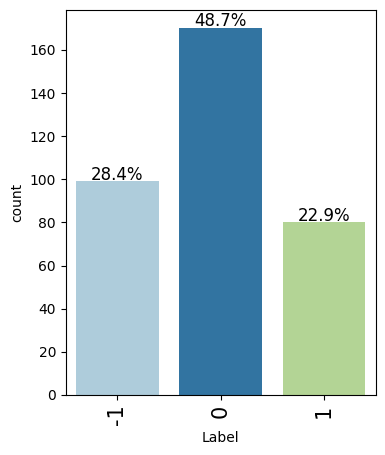

In [ ]:
# Check count per Sentiment in Label column
print(f"Label Count = {stock_news_df['Label'].value_counts()}");

# Percentage of Sentiments among Lalels
labeled_barplot(stock_news_df, "Label", perc=True);

**Observations**

- Majority of the reviews are Neutral ~48.7%.
- Followed by negative reviews ~28.4%.
- Positive reviews are ~22.9%.

#### **Observations on News article length**

In [ ]:
# Calculating the total number of words present in the news article content.
stock_news_df['News_Length'] = stock_news_df['News'].apply(lambda x: len(x.split(' ')))

# Print the statistical summary for the news content length
stock_news_df['News_Length'].describe()

,News_Length
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000


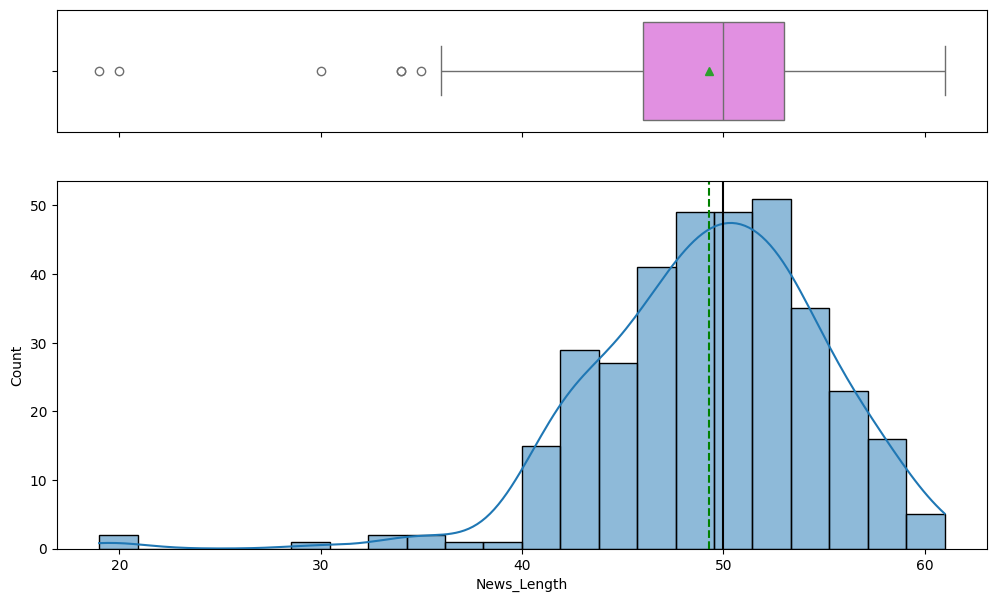

In [ ]:
# Create the Histogram and boxplot for News_Length Column
histogram_boxplot(stock_news_df, 'News_Length',kde='True')

**Observations**

- The distribution of words in news article appears to be left skewed.
- Most news article words counts are concentrated within the range of 46 to 53 words.
- The mean news article words counts is approximately 49 words.
- The News Length column has some lower outliers with word count as low as 20.

#### **Let's look at spread of Open Column**

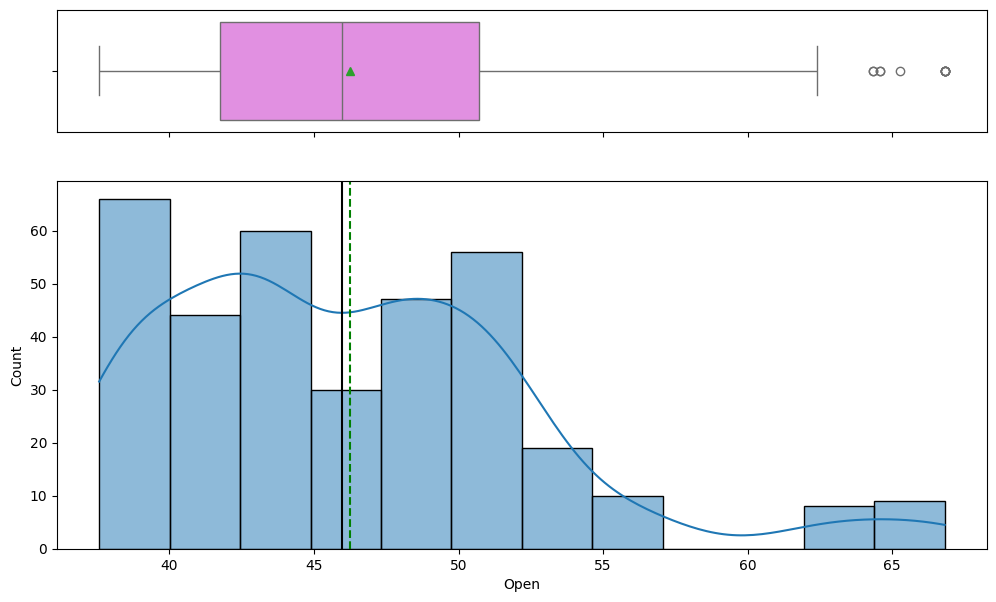

In [ ]:
# Create the Histogram and boxplot for Open Column
histogram_boxplot(stock_news_df, 'Open',kde='True')

**Observations**

- The distribution of stock price appears to be slightly rightly skewed
- Most stock prices concentrated within the range of 42 to 51 dollars.
- The mean stock price is approximately ~46 dollars.
- The Open column has some upper outliers.

#### **Let's look at spread of High Column**

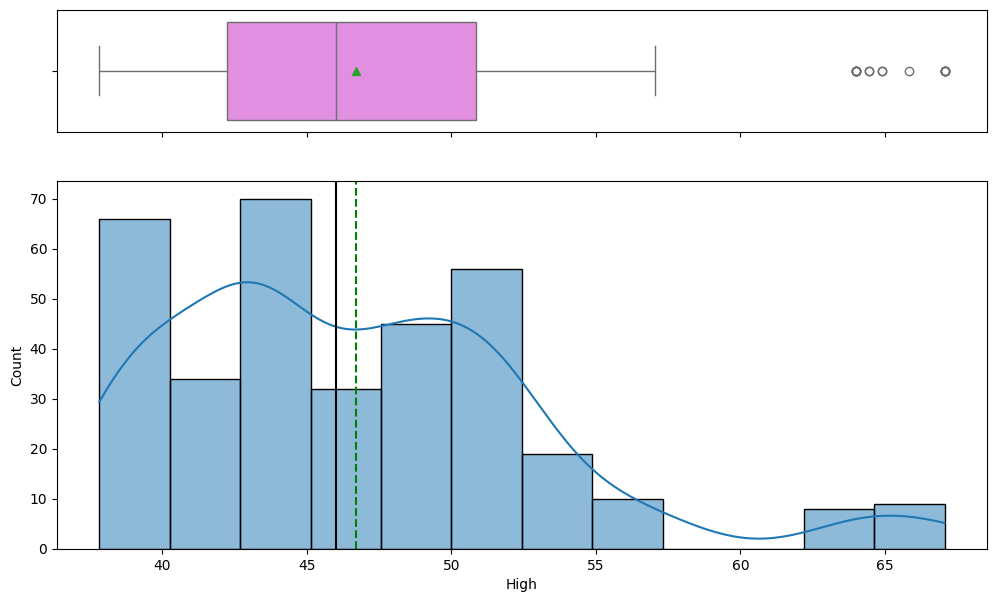

In [ ]:
# Create the Histogram and boxplot for High Column
histogram_boxplot(stock_news_df, 'High',kde='True')

**Observations**

- The distribution of high stock price appears to be slightly rightly skewed as well.
- Most high stock prices concentrated within the range of 42 to 51 dollars.
- The mean stock price is approximately ~46 dollars.
- The High column has some upper outliers.

#### **Let's look at spread of Low Column**

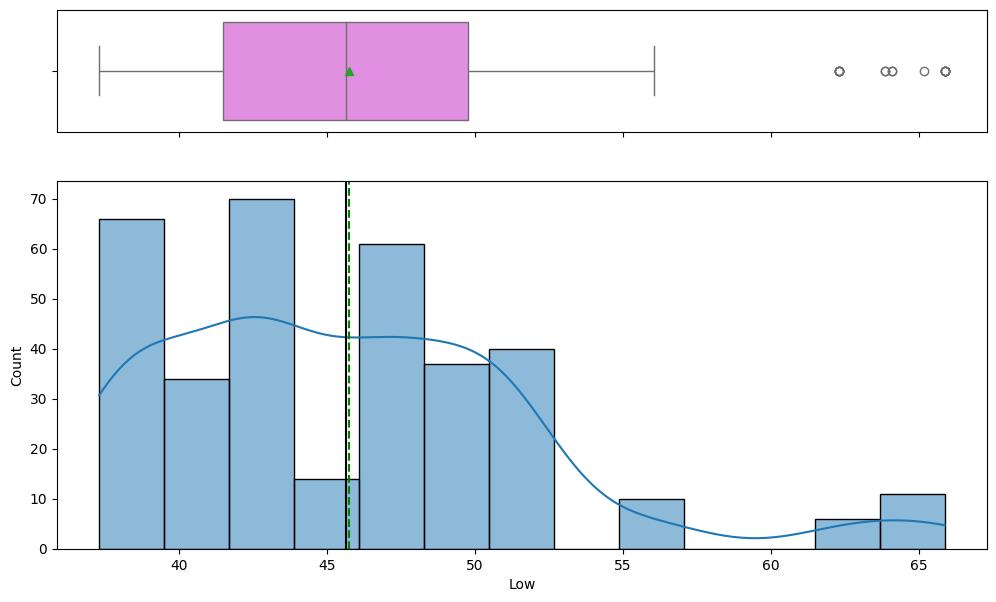

In [ ]:
# Create the Histogram and boxplot for Low Column
histogram_boxplot(stock_news_df, 'Low',kde='True')

**Observations**

- The distribution of Low stock price appears to be slightly rightly skewed as well.
- Most Low stock prices concentrated within the range of 42 to 50 dollars.
- The mean stock price is approximately ~45 dollars.
- The Low column has some upper outliers.

#### **Let's look at spread of Close Column**

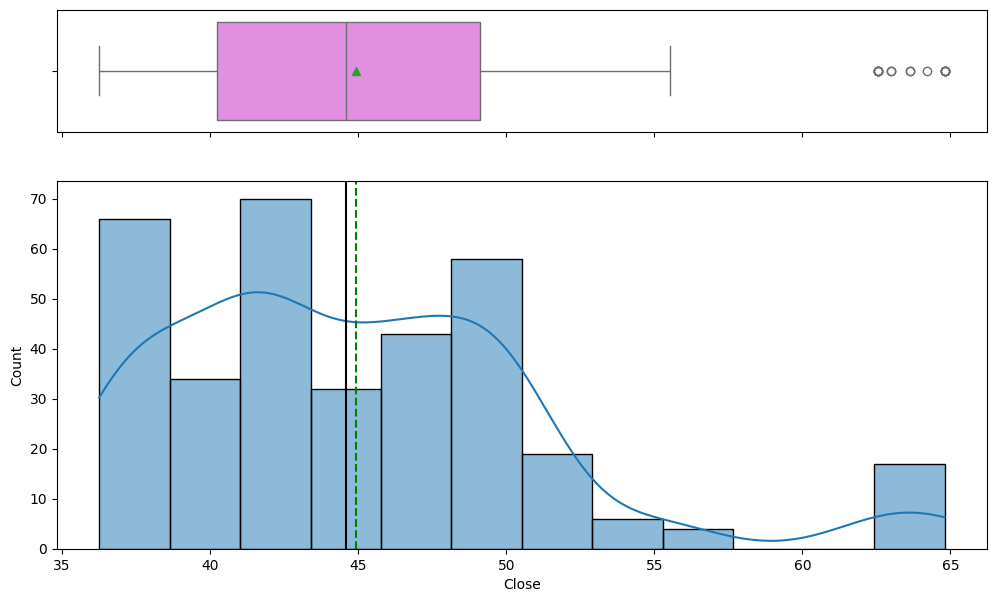

In [ ]:
# Create the Histogram and boxplot for Close Column
histogram_boxplot(stock_news_df, 'Close',kde='True')

**Observations**

- The distribution of Close stock price appears to be slightly rightly skewed as well.
- Most Close stock prices concentrated within the range of 40 to 49 dollars.
- The mean stock price is approximately ~45 dollars.
- The Close column has some upper outliers.

#### **Let's look at spread of Volume Column**

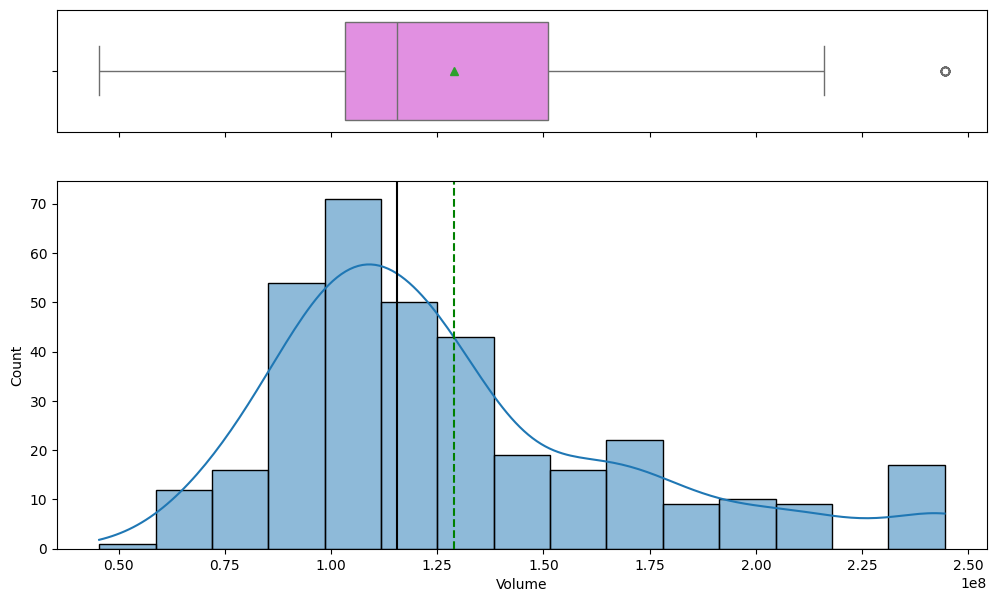

In [ ]:
# Create the Histogram and boxplot for Volume Column
histogram_boxplot(stock_news_df, 'Volume',kde='True')

**Observations**

- The Volume distribution of stocks seems to be almost uniform.
- Mostly stocks traded per day concentrated within the range of 103272000 to 151125200.
- The mean stock volume traded per day is approximately 128948236.10.
- The volume column has one outlier.

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

In [ ]:
### Function to plot distributions
def distribution_plot_wrt_target(data, predictor, target):
    fig, axs = plt.subplots(2, 3, figsize=(12, 10))

    target_uniq = data[target].unique()

    # First row - Histograms
    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    if len(target_uniq) > 2:
        axs[0, 2].set_title("Distribution of target for target=" + str(target_uniq[2]))
        sns.histplot(
            data=data[data[target] == target_uniq[2]],
            x=predictor,
            kde=True,
            ax=axs[0, 2],
            color="green",
        )
    else:
        fig.delaxes(axs[0, 2])  # Remove the unused subplot if there are fewer than 3 targets

    # Second row - Boxplots
    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    fig.delaxes(axs[1, 2])  # Explicitly remove the extra plot in the second row

    plt.tight_layout()
    plt.show()

#### **Let's look at the co-relation between all numeric columns**

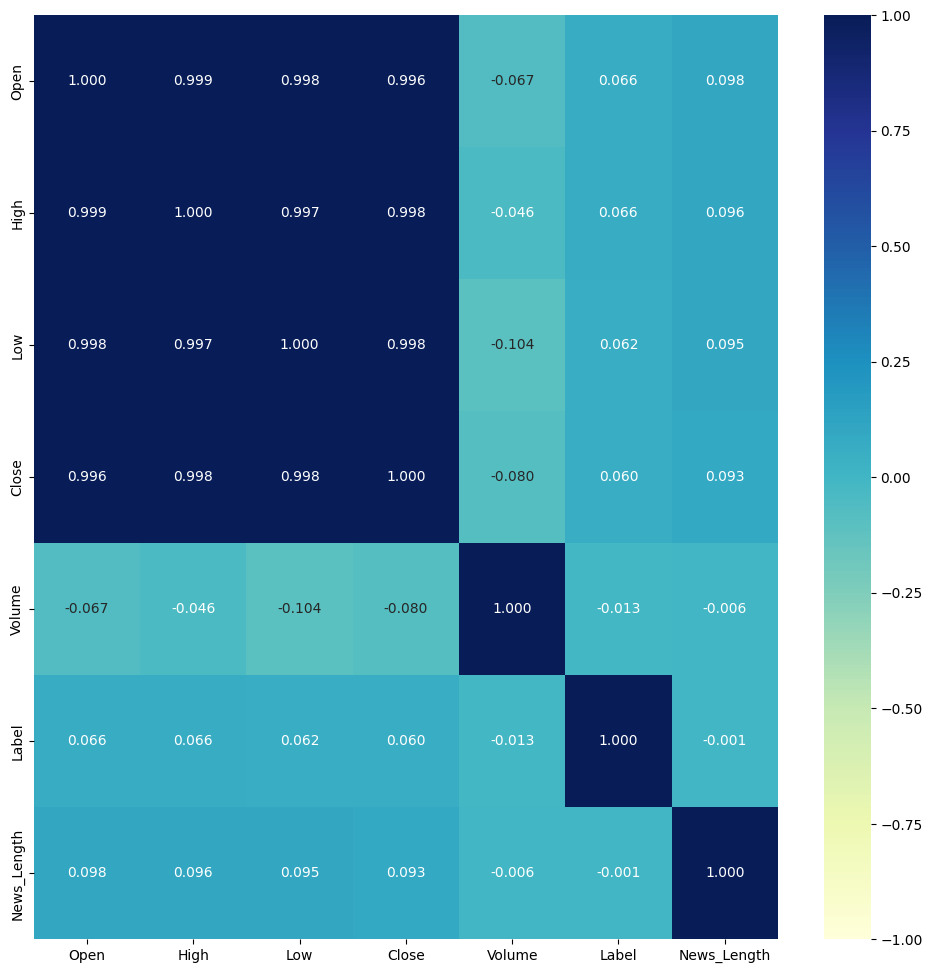

In [ ]:
# Co-relation between all numeric columns up to 3 decimals
plt.figure(figsize =(12,12))
sns.heatmap(data = stock_news_df.select_dtypes(include=np.number).corr(),annot = True,cmap='YlGnBu',fmt=".3f",vmin=-1,vmax=1)
plt.show()

**Observations**

- Open, High, Low and Close are highly co-related which is showing multicollinearity.
- Volume column does not has a co-relation with any other column.
- Label column does not has shows co-relation with any other column.
- New Length column does not has a co-relation with any other column.

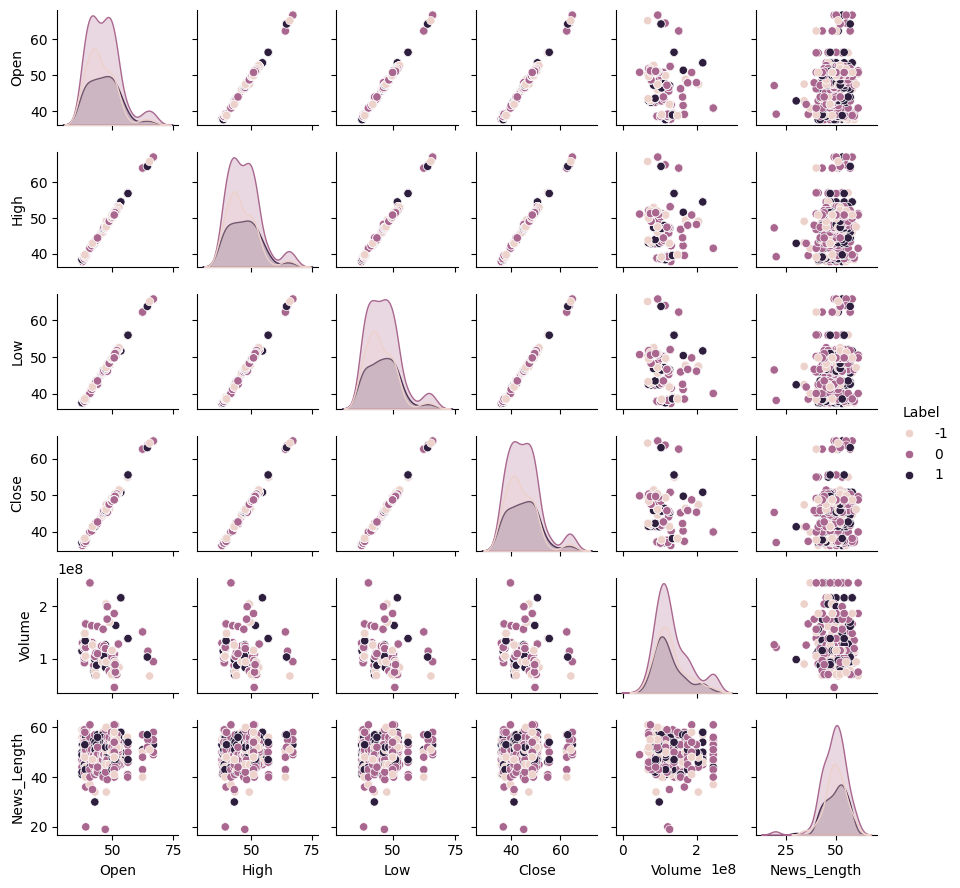

In [ ]:
# Relationship between all numeric columns
sns.pairplot(data=stock_news_df,hue='Label',height = 1.5);

#### **Let's look at the relationship between Label vs Open**

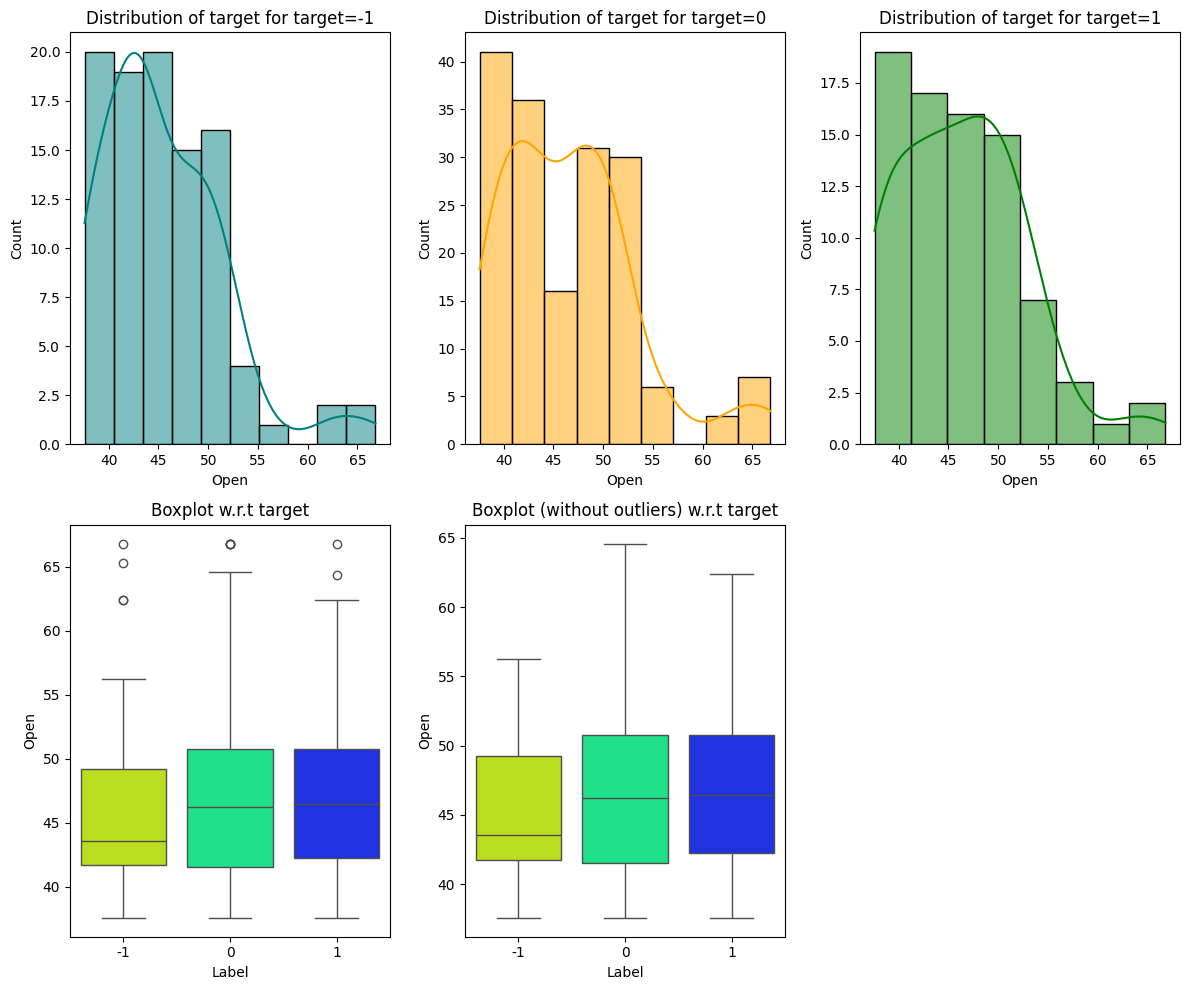

In [ ]:
# Relationship between News Label vs Open Column
distribution_plot_wrt_target(stock_news_df,'Open','Label')

**Observationns**

- Negative sentiment: Stock open price data shows slightly right skew distribution with some outliers, where 50% of data in range of ~42 to ~48 dollars.
- Neutral sentiment: Stock open price data shows shows slightly right skew distribution with some outliers, where 50% of data in range of ~42 to ~51 dollars.
- Positive sentiment: Stock open price data shows shows slightly right skew distribution with some outliers, where 50% of data in range of ~42.5 to ~51 dollars.
- **Sentiments does not show any impact on Stocks Open Price.**

#### **Let's look at the relationship between Label vs High**

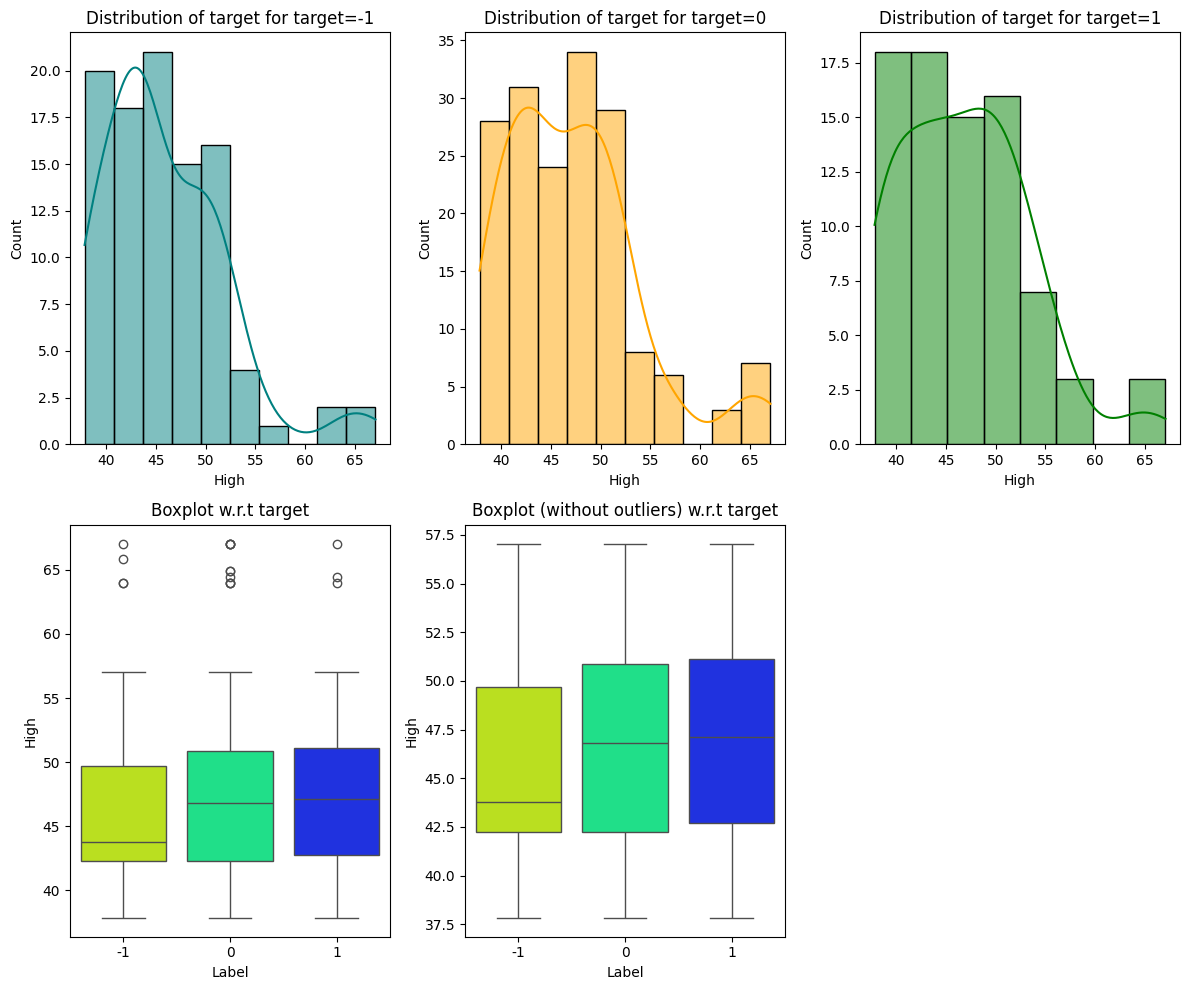

In [ ]:
# Relationship between News Label vs High Column
distribution_plot_wrt_target(stock_news_df,'High','Label')

**Observationns**

- Negative sentiment: Stock High price data shows slightly right skew distribution with some outliers, where 50% of data in range of ~42 to ~48 dollars.
- Neutral sentiment: Stock High price data shows shows slightly right skew distribution with some outliers, where 50% of data in range of ~42 to ~51 dollars.
- Positive sentiment: Stock High price data shows shows slightly right skew distribution with some outliers, where 50% of data in range of ~42.5 to ~51 dollars.
- **Sentiments does not show any impact on Stocks High Price.**

#### **Let's look at the relationship between Label vs Low**

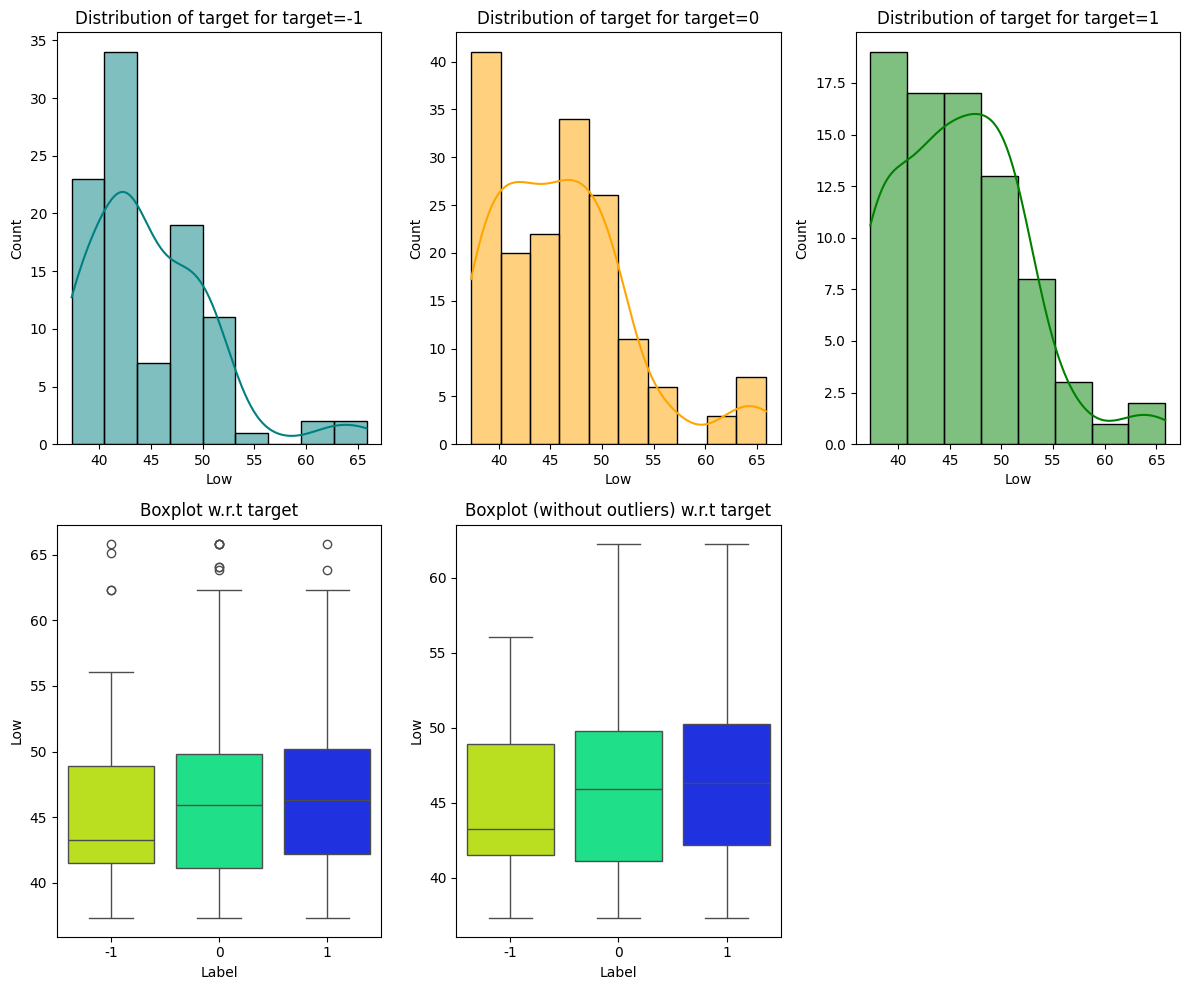

In [ ]:
# Relationship between News Label vs Low Column
distribution_plot_wrt_target(stock_news_df,'Low','Label')

**Observationns**

- Negative sentiment: Stock Low price data shows slightly right skew distribution with some outliers, where 50% of data in range of ~42 to ~49 dollars.
- Neutral sentiment: Stock Low price data shows shows slightly right skew distribution with some outliers, where 50% of data in range of ~41 to ~50 dollars.
- Positive sentiment: Stock Low price data shows shows slightly right skew distribution with some outliers, where 50% of data in range of ~42.5 to ~51 dollars.
- **Sentiments does not show any impact on Stocks Low Price.**

#### **Let's look at the relationship between Label vs Close**

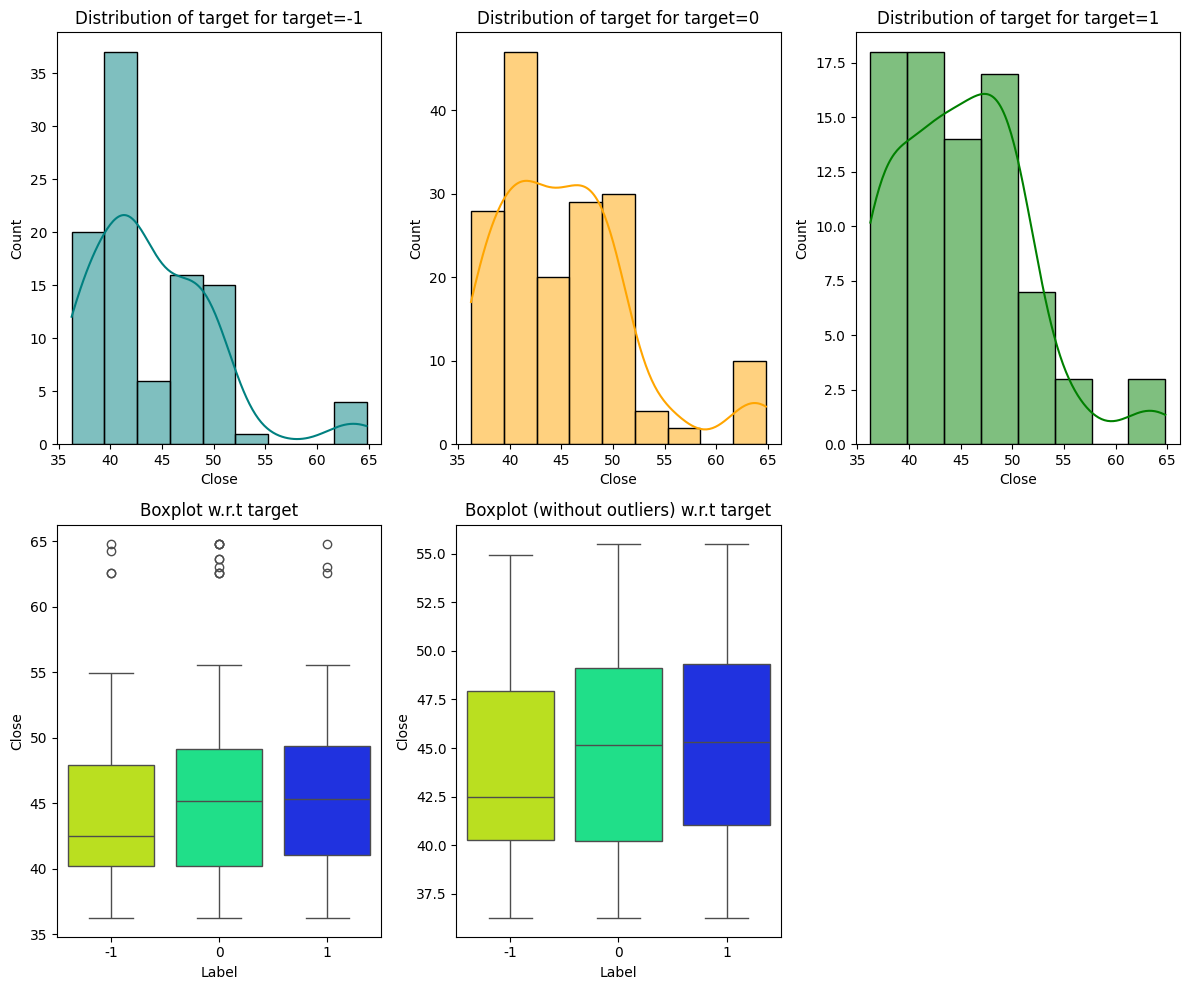

In [ ]:
# Relationship between News Label vs Close Column
distribution_plot_wrt_target(stock_news_df,'Close','Label')

**Observationns**

- Negative sentiment: Stock Close price data shows slightly right skew distribution with some outliers, where 50% of data in range of ~40 to ~48 dollars.
- Neutral sentiment: Stock Close price data shows shows slightly right skew distribution with some outliers, where 50% of data in range of ~40 to ~49 dollars.
- Positive sentiment: Stock Close price data shows shows slightly right skew distribution with some outliers, where 50% of data in range of ~42.5 to ~49 dollars.
- **Sentiments does not show any impact on Stocks Close Price.**

#### **Let's look at the relationship between Label vs Volume**

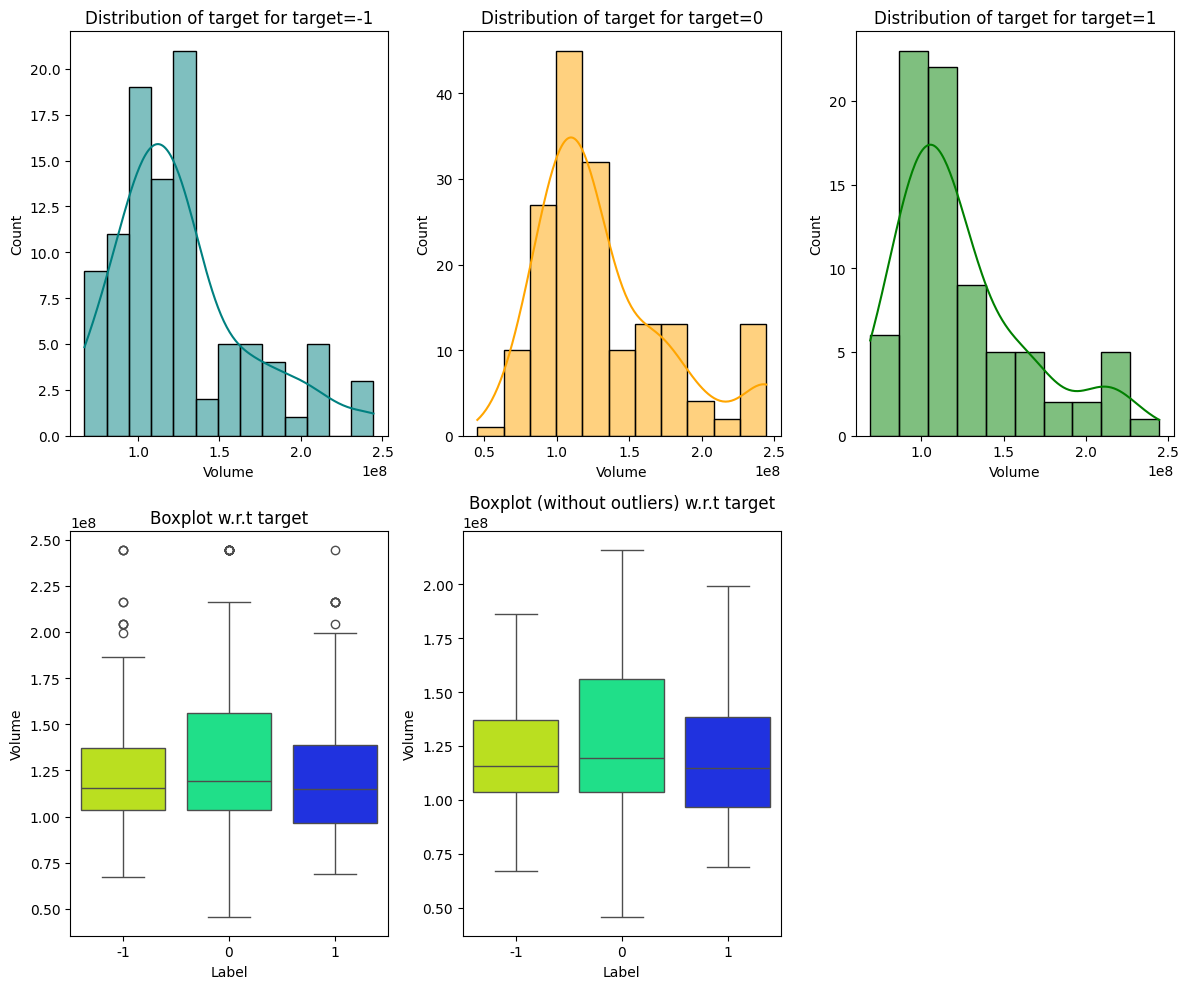

In [ ]:
# Relationship between News Label vs Volume Column
distribution_plot_wrt_target(stock_news_df,'Volume','Label')

**Observationns**

- Negative sentiment: Stock volume data appears to be uniformly distributed with minimal right skew with some outliers.
- Neutral sentiment: Stock volume data appears to be uniformly distributed with minimal right skew with some outliers.
- Positive sentiment: Stock volume data appears to be uniformly distributed with minimal right skew with some outliers.
- **Sentiments does not show any such impact on Stocks Volumes because Negative and Positive sentiments data appers almost same whereas Neutral sentinment stocks shares maximum stocks volume.**

#### **Let's look at the relationship between Date vs Price (Open, High, Low, Close)**

In [ ]:
# Prepare a dataframe containing mean values of all Stock price columns group by date
stock_daily = stock_news_df.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


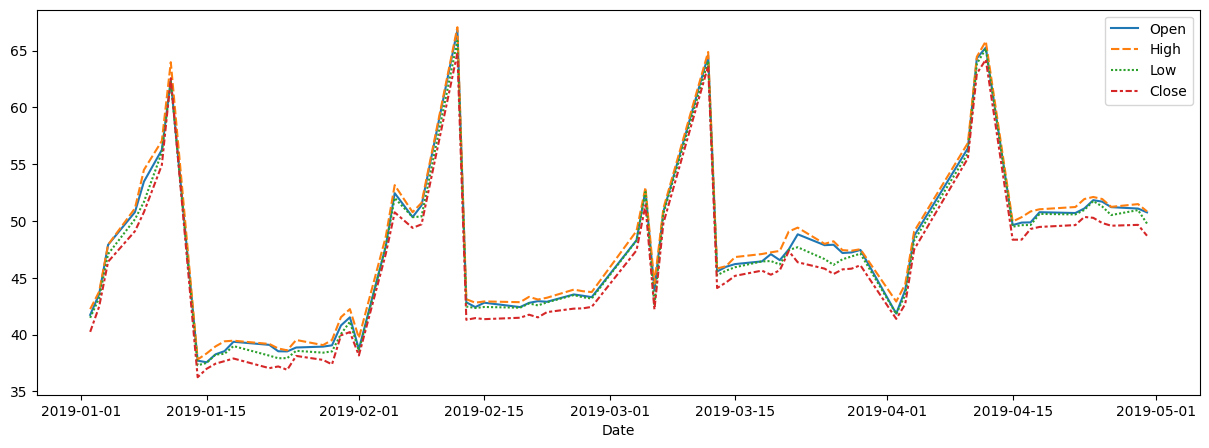

In [ ]:
# Plot a lineplot of all the variables except Volume
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop("Volume", axis=1));

**Observationns**

- Average Prices(open, close, high, low) distribution of stocks shows a pattern where from starting of each month stocks prices starts to increase from lowest level and reaches to months high just before mid month and then again sharply  decrease to its lowest level and remain almost same till the start of next month and repeats the same for next month.

#### **Let's look at the relationship between Volumne and Close Price date wise**

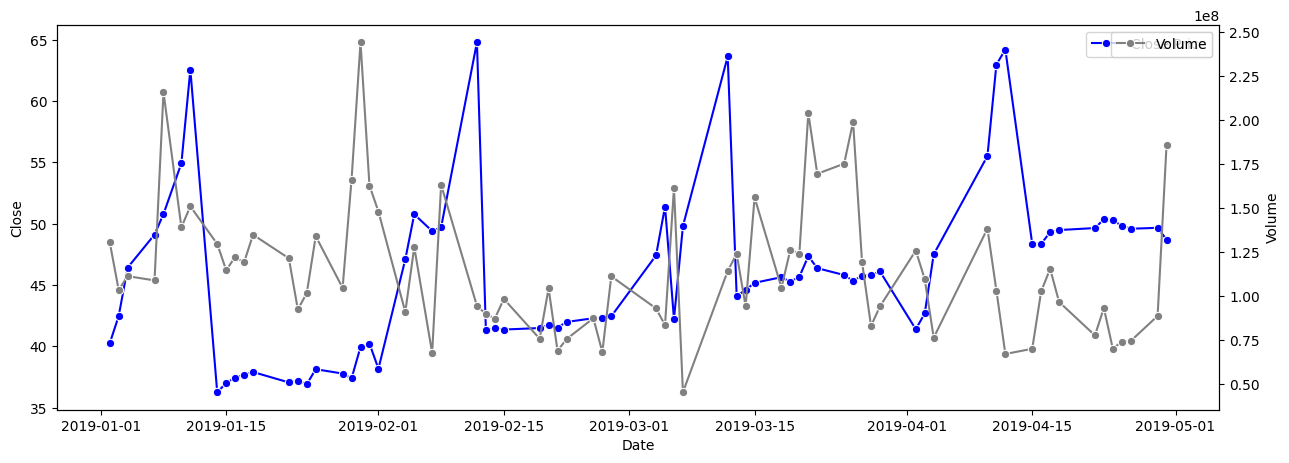

In [ ]:
# Create a figure and axis to display Close Price range
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis, i.e Close Price
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis to display Volume range
ax2 = ax1.twinx()

# Lineplot on secondary y-axis, i.e Volume
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

# Display the legend
ax1.legend(bbox_to_anchor=(1,1));

**Observationns**

- Close Price distribution of stocks does not shows any such replationship pattern with the volume of shares.

## **Data Preprocessing**

In [ ]:
# Print the statistical summary of the 'Date' column
stock_news_df['Date'].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


### **Train-test-validation Split**

In [ ]:
# Splitting the data for train, Validation and Test sets

# Select all rows where the 'Date' is before '2019-04-01' for training data set
X_train = stock_news_df[(stock_news_df['Date'] < '2019-04-01')].reset_index()

# Select all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded) for validation data set
X_val = stock_news_df[(stock_news_df['Date'] >= '2019-04-01') & (stock_news_df['Date'] < '2019-04-16')].reset_index()

# Select all rows where the 'Date' is from '2019-04-16' till the end for test dataset
X_test = stock_news_df[stock_news_df['Date'] >= '2019-04-16'].reset_index()

In [ ]:
# Prepare target dataframe for 'Label' column as the target variable
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [ ]:
# Print the shape of Train, Validation and test data set along with percentage to dispay proportion distribution
print("Shape of training set:", X_train.shape, y_train.shape)
print("Shape of validation set:", X_val.shape, y_val.shape)
print("Shape of test set:", X_test.shape, y_test.shape)
print('\n')
print("Percentage of classes in training set:")
print(100*y_train.value_counts(normalize=True), '\n')
print("Percentage of classes in validation set:")
print(100*y_val.value_counts(normalize=True), '\n')
print("Percentage of classes in test set:")
print(100*y_test.value_counts(normalize=True))

Shape of training set: (286, 10) (286,)
Shape of validation set: (21, 10) (21,)
Shape of test set: (42, 10) (42,)


Percentage of classes in training set:
Label
 0    48.251748
-1    28.671329
 1    23.076923
Name: proportion, dtype: float64 

Percentage of classes in validation set:
Label
 0    57.142857
 1    23.809524
-1    19.047619
Name: proportion, dtype: float64 

Percentage of classes in test set:
Label
 0    47.619048
-1    30.952381
 1    21.428571
Name: proportion, dtype: float64


## **Word Embeddings**

### **Word Embedding using Word2Vec**

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock_news_df['News'].values]

In [ ]:
# Creating an instance of Word2Vec

# Set the Vector Size for Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


Let's check out a few word embeddings obtained using the model.

In [ ]:
# Checking the word embedding of a random word
word = "price"
model_W2V.wv[word]

array([-0.000102  ,  0.03644104, -0.00033538,  0.02429032, -0.00536047,
       -0.0379624 ,  0.02555334,  0.07021961,  0.00274222, -0.00682097,
        0.00911443, -0.0162421 ,  0.00314988,  0.00994242, -0.01993902,
       -0.02330899,  0.01971591, -0.01278009,  0.00187882, -0.00988075,
       -0.02104705, -0.0013894 ,  0.03182852,  0.0030725 ,  0.01497688,
        0.00560705, -0.03853429,  0.00440984, -0.01617444, -0.02802703,
        0.01010948, -0.01688352,  0.00141755, -0.00324033, -0.00407184,
        0.01067054,  0.01159747, -0.02887855, -0.00125569, -0.00903869,
       -0.01335177, -0.00529973, -0.00086538, -0.01764862,  0.0121507 ,
        0.03484925, -0.00435687,  0.00825764, -0.00261256,  0.02380468,
        0.01507199,  0.00792425, -0.01251474,  0.00988369, -0.00616683,
        0.02122555,  0.01268128,  0.00419813,  0.0096485 , -0.00220076,
       -0.00445996, -0.01252328, -0.00155691,  0.00428999,  0.00560029,
        0.01347899,  0.00079641,  0.01528181, -0.01798625, -0.00

In [ ]:
# Checking the word embedding of a random word
word = "forecast"
model_W2V.wv[word]

array([-2.53896508e-03,  1.73722357e-02,  1.84729358e-03,  1.24390461e-02,
       -2.86879484e-03, -1.54000232e-02,  1.54711166e-02,  3.26148979e-02,
        5.72415674e-03, -6.87078899e-03,  6.97849039e-03, -8.17745365e-03,
        1.52512093e-03,  5.83005976e-03, -7.97752105e-03, -1.20972646e-02,
        9.38786846e-03, -8.35755654e-03,  1.04063156e-03, -5.10377297e-03,
       -1.21471845e-02,  1.68212072e-03,  1.56473834e-02,  2.55447323e-03,
        4.21784772e-03, -1.28102931e-03, -1.83915775e-02,  5.35266614e-03,
       -7.40296766e-03, -1.15249762e-02,  2.78061442e-03, -3.80880060e-03,
       -1.82036043e-03, -2.27599521e-03, -8.01473565e-04,  6.08238624e-03,
        3.85740283e-03, -1.35138910e-02,  1.17075758e-03, -1.16231688e-03,
       -7.15044700e-03, -3.78289795e-03, -8.67786177e-04, -1.15164472e-02,
        4.15952085e-03,  1.67139135e-02, -8.76577338e-04,  5.59610315e-03,
       -3.00719639e-05,  9.07885935e-03,  3.99275031e-03,  5.68037061e-03,
       -1.00807305e-02,  

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.7398197650909424


In [ ]:
# Print the shapes of the final dataframes
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


- Each news content has been converted to a 300-dimensional vector.

### **Word Embedding using Glove**

In [ ]:
# Load the Stanford GloVe model
filename = '/content/drive/MyDrive/python/NLP/Project/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


Let's check out a few word embeddings.

In [ ]:
# Checking the word embedding of a random word
word = "price"
glove_model[word]

array([ 3.3108e-01,  1.9364e-01,  1.6607e-01,  8.6574e-02, -2.0639e-01,
       -1.4334e+00, -2.9923e-01, -1.1618e-01, -6.6627e-01, -1.4150e-01,
        2.1907e-01,  1.6721e-01, -1.6150e-01, -2.8570e-01,  2.7179e-01,
        9.5956e-02, -9.7168e-01,  1.0444e-01,  1.0485e-01,  1.3673e-01,
        8.3398e-01, -6.8866e-01,  2.6409e-01,  2.9890e-01,  5.9473e-01,
        1.4549e-02,  1.7850e-02, -9.5206e-01, -6.6171e-01, -2.2428e-01,
        3.2354e-01,  5.7278e-01, -7.1502e-02, -1.4367e-01,  3.1574e-01,
        7.4511e-01,  7.5837e-01, -1.7850e-03,  1.0807e-01, -9.9260e-01,
        2.5383e-01, -5.2487e-01, -1.3455e-01, -3.1672e-01,  3.7978e-02,
        4.0723e-01, -5.5722e-01, -1.0508e+00,  5.0940e-03, -1.4605e+00,
        8.2840e-01, -1.4003e-01, -9.2980e-03,  8.4426e-01, -2.6589e-01,
       -2.1714e+00, -5.7227e-02, -1.6759e-01,  2.0411e+00, -2.6865e-01,
        4.3311e-01, -4.7494e-01, -8.3282e-01,  4.2100e-01,  3.4240e-01,
       -5.1296e-01,  6.7027e-01, -2.9009e-01,  7.7592e-01, -1.89

In [ ]:
# Checking the word embedding of a random word
word = "forecast"
glove_model[word]

array([-0.79199  , -0.072273 ,  0.57128  ,  0.023189 , -0.14358  ,
       -1.6779   ,  0.20246  ,  0.2148   , -0.7455   ,  0.43791  ,
       -0.12105  ,  0.24679  ,  0.50019  , -0.57842  ,  0.88236  ,
       -0.067721 , -0.27787  , -0.10945  ,  0.86534  ,  0.28721  ,
        0.4951   , -0.1419   , -0.21244  ,  1.346    , -0.5487   ,
       -0.42349  , -0.10071  , -0.0022178, -0.54291  , -0.37046  ,
        0.11382  , -0.22779  , -0.33873  ,  0.077944 , -0.73082  ,
        0.87067  ,  0.24092  , -0.032286 ,  0.16778  , -0.077403 ,
       -0.82313  , -0.4036   , -0.37206  ,  0.45621  ,  0.18566  ,
       -0.52829  ,  0.6343   , -0.81295  , -0.17307  , -1.4709   ,
        0.62746  , -0.43121  ,  0.56417  ,  0.29279  , -0.0053127,
       -1.9638   ,  0.21923  ,  0.14547  ,  1.0531   ,  0.59927  ,
        0.27735  , -0.23879  , -1.2735   , -0.033996 , -0.72418  ,
        0.35974  , -0.93533  ,  0.16424  ,  1.0164   , -0.69448  ,
        0.53146  ,  0.72598  , -0.2579   , -0.21708  ,  0.2751

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
# Set the Vector Size for Glove
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# Creating a dataframe of the vectorized documents
start = time.time()

# Apply GloVe on 'News' column
X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  30.55774998664856


In [ ]:
# Print the shapes of the final dataframes
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


- Each news content has been converted to a 100-dimensional vector.

### **Word Embedding using Sentence Transformer**


#### **Defining the model**

In [ ]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

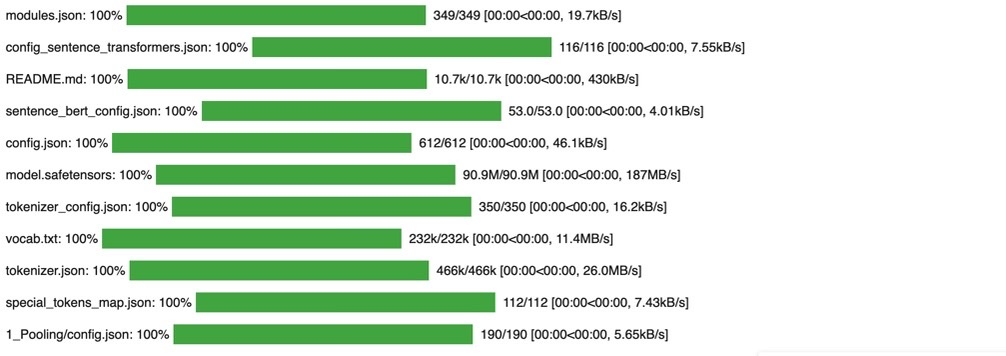

#### **Encoding the dataset**

In [ ]:
    # Setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Encoding the dataset
start = time.time()

# Apply Sentence Transformer on 'News' column
X_train_st = model.encode(X_train['News'].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

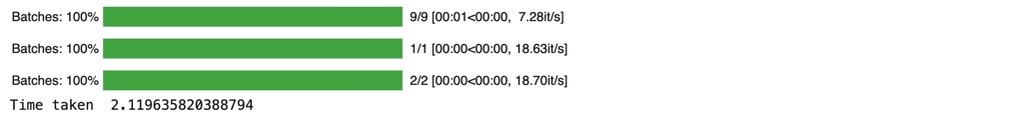

In [ ]:
# Print the shapes of the final dataframes
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)

(286, 384) (21, 384) (42, 384)


- Each news content has been converted to a 384-dimensional vector.

## **Sentiment Analysis**

### **Utility Functions**


In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

In [ ]:
models = []  # Empty list to store all the models
RS = 42

# Appending models into the list
models.append(("Random forest", RandomForestClassifier(random_state=RS)))
models.append(("GBM", GradientBoostingClassifier(random_state=RS)))
models.append(("dtree", DecisionTreeClassifier(random_state=RS)))

### **Base Model - Word2Vec**

In [ ]:
models_train_f1_score = []  # Empty list to store all the training score
models_validation_f1_score = []  # Empty list to store all the validation score

for name, model in models:
        model.fit(X_train_wv, y_train)
        # Calculate f1 scores
        scores_f1 = f1_score(y_train, model.predict(X_train_wv), average='weighted')
        models_train_f1_score.append((name,scores_f1))
        scores_val_f1 = f1_score(y_val, model.predict(X_val_wv), average='weighted')
        models_validation_f1_score.append((name,scores_val_f1))

# Convert models list into 2 columns data frame
models_train_f1_score_df = pd.DataFrame(models_train_f1_score, columns=['Model Name', 'F1 Score'])
models_validation_f1_score_df = pd.DataFrame(models_validation_f1_score, columns=['Model Name', 'F1 Score'])

# Merge models_train_f1_score_df and models_train_score_df into one data frame
models_score_df = pd.merge(models_train_f1_score_df, models_validation_f1_score_df, on='Model Name', suffixes=('_train_W2V', '_val_W2V'))

In [ ]:
# Print the weighted F1 Score for each model
models_score_df

,Model Name,F1 Score_train_W2V,F1 Score_val_W2V
0,Random forest,1.0,0.315271
1,GBM,1.0,0.315271
2,dtree,1.0,0.338462


- **Observations**
  - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set but shows slghtly better performance than other models.
  - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set.
  - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set.
    
**Next Steps**
 - Let’s proceed to use Decision Tree model to determine detailed performs on both training and validation sets, aiming to check the highest F1 score.

In [ ]:
# Building the Decision Tree model
base_wv = DecisionTreeClassifier(random_state=RS)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

DecisionTreeClassifier(random_state=42)

**Let's print the Confusion matrix**

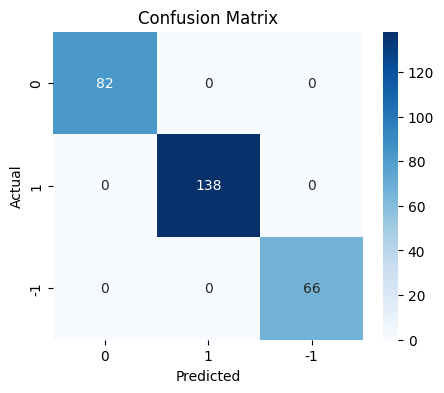

In [ ]:
#Print confusin matrix on on training data
plot_confusion_matrix(base_wv,X_train_wv,y_train)

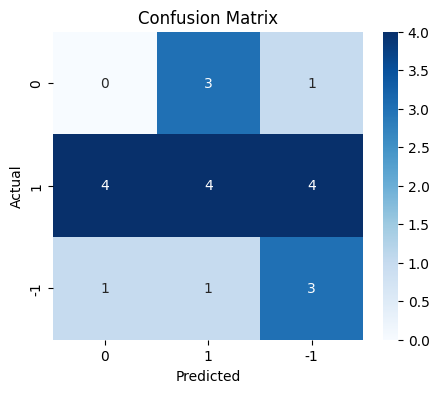

In [ ]:
#Print confusin matrix on on Validation data
plot_confusion_matrix(base_wv,X_val_wv,y_val)

**Let's print Training performance:**

In [ ]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Let's print Validation performance:**

In [ ]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.333333  0.333333      0.375  0.338462


- Train F1 score of 1 and validation F1 score of ~0.33 indicate poor performance of the model between training and validation datasets while calculating using weighted average.

**Classification Report**

In [ ]:
# Print classification report on training data
print(classification_report(y_train, base_wv.predict(X_train_wv)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286



In [ ]:
# Print classification report on validation data
print(classification_report(y_val, base_wv.predict(X_val_wv)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.50      0.33      0.40        12
           1       0.38      0.60      0.46         5

    accuracy                           0.33        21
   macro avg       0.29      0.31      0.29        21
weighted avg       0.38      0.33      0.34        21



**Observations**
  - For class -1, Train and validaiton F1 Score is 1 and 0 respectively and shows overfitting.
  - For class 0, Train and validaiton F1 Score is 1 and 0.40 respectively and shows overfitting.
  - For class 1, Train and validaiton F1 Score is 1 and 0.46 respectively and shows overfitting.
  - Model seems much Bias towards class 1 while predecting if we compare from any other class
  - Model failed for predecting class -1 entirely.

### **Base Model - GloVe**

In [ ]:
models_train_glove_f1_score = []  # Empty list to store all the training score
models_validation_glove_f1_score = []  # Empty list to store all the validation score

for name, model in models:
        model.fit(X_train_gl, y_train)
        # Calculate f1 scores
        scores_f1 = f1_score(y_train, model.predict(X_train_gl), average='weighted')
        models_train_glove_f1_score.append((name,scores_f1))
        scores_val_f1 = f1_score(y_val, model.predict(X_val_gl), average='weighted')
        models_validation_glove_f1_score.append((name,scores_val_f1))

#Convert models list into 2 columns data frame
models_train_glove_f1_score_df = pd.DataFrame(models_train_glove_f1_score, columns=['Model Name', 'F1 Score'])
models_validation_glove_f1_score_df = pd.DataFrame(models_validation_glove_f1_score, columns=['Model Name', 'F1 Score'])

# merge models_train_glove_f1_score_df and models_validation_glove_f1_score_df into one data frame
models_score_glove_df = pd.merge(models_train_glove_f1_score_df, models_validation_glove_f1_score_df, on='Model Name', suffixes=('_train_Glove', '_val_Glove'))

In [ ]:
# Print the weighted F1 Score for each model
models_score_glove_df

,Model Name,F1 Score_train_Glove,F1 Score_val_Glove
0,Random forest,1.0,0.426871
1,GBM,1.0,0.351648
2,dtree,1.0,0.438672


- **Observations**
  - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set but shows slghtly better performance than other models.
  - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set.
  - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set.
    
**Next Steps**
 - Let’s proceed to use Decision Tree model to determine detailed performs on both training and validation sets, aiming to check the highest F1 score.

In [ ]:
# Building the model
base_gl = DecisionTreeClassifier(random_state=RS)

# Fitting on train data
base_gl.fit(X_train_gl, y_train)

DecisionTreeClassifier(random_state=42)

**Let's print the Confusion matrix**

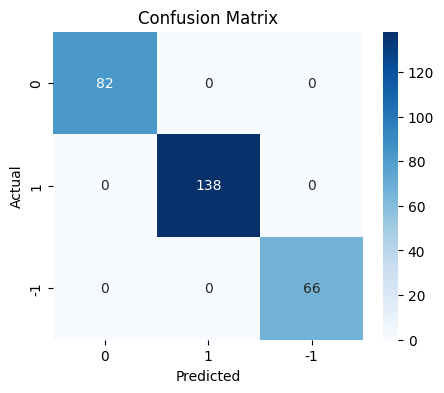

In [ ]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(base_gl,X_train_gl,y_train)

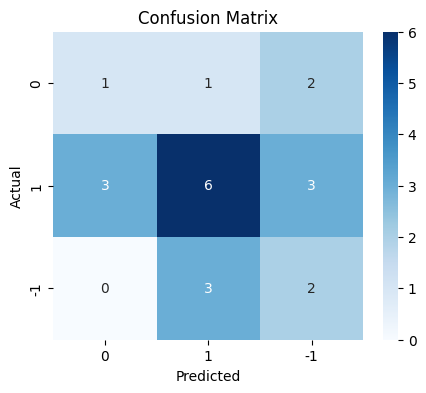

In [ ]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(base_gl,X_val_gl,y_val)

**Let's print Training performance:**

In [ ]:
# Calculating different metrics on training data
base_train_gl=model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Let's print Validation performance:**

In [ ]:
# Calculating different metrics on validation data
base_val_gl=model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.458503  0.438672


- Train F1 score of 1 and validation F1 score of ~0.43 indicate poor performance of the model between training and validation datasets while calculating using weighted average.

**Classification Report**

In [ ]:
#Print classification report on training data
print(classification_report(y_train, base_gl.predict(X_train_gl)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286



In [ ]:
#Print classification report on validation data
print(classification_report(y_val, base_gl.predict(X_val_gl)))

              precision    recall  f1-score   support

          -1       0.25      0.25      0.25         4
           0       0.60      0.50      0.55        12
           1       0.29      0.40      0.33         5

    accuracy                           0.43        21
   macro avg       0.38      0.38      0.38        21
weighted avg       0.46      0.43      0.44        21



**Observations**
  - For class -1, Train and validaiton F1 Score is 1 and .25 respectively and shows overfitting.
  - For class 0, Train and validaiton F1 Score is 1 and 0.55 respectively and shows overfitting.
  - For class 1, Train and validaiton F1 Score is 1 and 0.33 respectively and shows overfitting.
  - Model seems much Bias towards class 0 while predecting if we compare from any other class
  - Model failed for predecting classes.

### **Base Model - Sentence Transformer**

In [ ]:
models_train_st_f1_score = []  # Empty list to store all the training score
models_validation_st_f1_score = []  # Empty list to store all the validation score

for name, model in models:
        model.fit(X_train_st, y_train)
        # Calculate f1 scores
        scores_f1 = f1_score(y_train, model.predict(X_train_st), average='weighted')
        models_train_st_f1_score.append((name,scores_f1))
        scores_val_f1 = f1_score(y_val, model.predict(X_val_st), average='weighted')
        models_validation_st_f1_score.append((name,scores_val_f1))

#Convert models list into 2 columns data frame
models_train_st_f1_score_df = pd.DataFrame(models_train_st_f1_score, columns=['Model Name', 'F1 Score'])
models_validation_st_f1_score_df = pd.DataFrame(models_validation_st_f1_score, columns=['Model Name', 'F1 Score'])


# Merge models_train_st_f1_score_df and models_validation_st_f1_score_df into one data frame
models_score_st_df = pd.merge(models_train_st_f1_score_df, models_validation_st_f1_score_df, on='Model Name', suffixes=('_train_ST', '_val_ST'))

In [ ]:
# Print the weighted F1 Score for each model
models_score_st_df

,Model Name,F1 Score_train_ST,F1 Score_val_ST
0,Random forest,1.0,0.504762
1,GBM,1.0,0.368664
2,dtree,1.0,0.480260


- **Observations**
  - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set.
  - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set but shows slghtly better performance than other models.
  - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set.
    
**Next Steps**
 - Let’s proceed to use Random Forest model to determine detailed performs on both training and validation sets, aiming to check the highest F1 score.

In [ ]:
# Building the model
base_st = RandomForestClassifier(random_state=RS)

# Fitting on train data
base_st.fit(X_train_st, y_train)

RandomForestClassifier(random_state=42)

**Let's print the Confusion matrix**

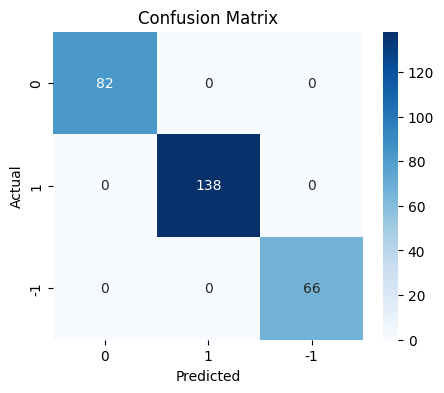

In [ ]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(base_st,X_train_st,y_train)

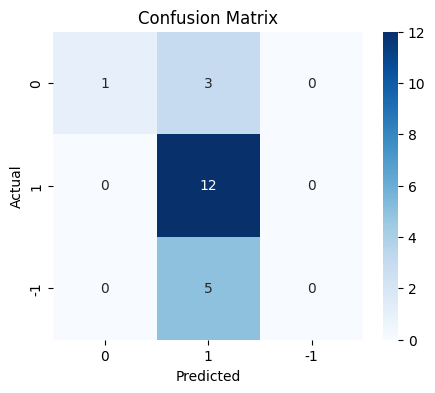

In [ ]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(base_st,X_val_st,y_val)

**Let's print Training performance:**

In [ ]:
# Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Let's print Validation performance:**

In [ ]:
# Calculating different metrics on validation data
base_val_st=model_performance_classification_sklearn(base_st,X_val_st,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.619048  0.619048   0.533333  0.504762


- Train F1 score of 1 and validation F1 score of ~0.50 indicate poor performance of the model between training and validation datasets while calculating using weighted average.

**Classification Report**

In [ ]:
#Print classification report on training data
print(classification_report(y_train, base_st.predict(X_train_st)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286



In [ ]:
#Print classification report on validation data
print(classification_report(y_val, base_st.predict(X_val_st)))

              precision    recall  f1-score   support

          -1       1.00      0.25      0.40         4
           0       0.60      1.00      0.75        12
           1       0.00      0.00      0.00         5

    accuracy                           0.62        21
   macro avg       0.53      0.42      0.38        21
weighted avg       0.53      0.62      0.50        21



**Observations**
  - For class -1, Train and validaiton F1 Score is 1 and .40 respectively and shows overfitting.
  - For class 0, Train and validaiton F1 Score is 1 and 0.75 respectively and shows overfitting.
  - For class 1, Train and validaiton F1 Score is 1 and 0 respectively and shows overfitting.
  - Model seems much Bias towards class 0 while predecting if we compare from any other class
  - Model failed for predecting class 1 completely.

### Score comparison on Training and Validation score for basic models

In [ ]:
# Merge models_score_df, models_score_over_df and models_score_under_df into one data frame
print("F1 Score comparison on Training and Validation score for basic models\n")
models_basic_score_final_df = pd.merge(models_score_df, models_score_glove_df, on='Model Name')
models_basic_score_final_df = pd.merge(models_basic_score_final_df, models_score_st_df, on='Model Name')
models_basic_score_final_df

F1 Score comparison on Training and Validation score for basic models



,Model Name,F1 Score_train_W2V,F1 Score_val_W2V,F1 Score_train_Glove,F1 Score_val_Glove,F1 Score_train_ST,F1 Score_val_ST
0,Random forest,1.0,0.315271,1.0,0.426871,1.0,0.504762
1,GBM,1.0,0.315271,1.0,0.351648,1.0,0.368664
2,dtree,1.0,0.338462,1.0,0.438672,1.0,0.480260


- **Observations**
  - **Word2Vec Base Model**
    - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set but shows slghtly better performance than other models.
    - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set.
    - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set.

  - **Glove Base Model**
    - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set but shows slghtly better performance than other models.
    - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set.
    - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set.

  - **Sentence Transformer Base Model**
    - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set.
    - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set but shows slghtly better performance than other models.
    - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set.

**Next Steps**
 - Let’s proceed to tune these models to determine which one performs best on both training and validation sets, aiming to achieve the highest F1 score.

### **Tuned Model - Word2Vec**

In [ ]:
models_train_f1_score = []  # Empty list to store all the training score
models_validation_f1_score = []  # Empty list to store all the validation score
models_est = [] # Empty list to store all the best estimator

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

for name, model in models:
    # Run the grid search
    grid_obj = RandomizedSearchCV(model, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
    grid_obj = grid_obj.fit(X_train_wv, y_train)
    # Set the clf to the best combination of parameters
    tuned_wv = grid_obj.best_estimator_
    # Fit the best algorithm to the data.
    tuned_wv.fit(X_train_wv, y_train)
    models_est.append((name,tuned_wv))
    # Calculate f1 scores
    scores_f1 = f1_score(y_train, tuned_wv.predict(X_train_wv), average='weighted')
    models_train_f1_score.append((name,scores_f1))
    scores_val_f1 = f1_score(y_val, tuned_wv.predict(X_val_wv), average='weighted')
    models_validation_f1_score.append((name,scores_val_f1))


# Convert models list into 2 columns data frame
models_train_f1_score_df = pd.DataFrame(models_train_f1_score, columns=['Model Name', 'F1 Score'])
models_validation_f1_score_df = pd.DataFrame(models_validation_f1_score, columns=['Model Name', 'F1 Score'])

# Merge models_train_f1_score_df and models_validation_f1_score_df into one data frame
models_score_df = pd.merge(models_train_f1_score_df, models_validation_f1_score_df, on='Model Name', suffixes=('_train_W2V', '_val_W2V'))

In [ ]:
# Print the weighted F1 Score for each model
models_score_df

,Model Name,F1 Score_train_W2V,F1 Score_val_W2V
0,Random forest,0.964869,0.342857
1,GBM,1.000000,0.342857
2,dtree,0.604421,0.327196


- **Observations**
  - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set.
  - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set but shows slghtly better performance than other models.
  - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set.
    
**Next Steps**
 - Let’s proceed to use Random Forest model to determine detailed performs on both training and validation sets, aiming to check the highest F1 score.

In [ ]:
models_est

[('Random forest',
  RandomForestClassifier(max_depth=5, max_features=0.4, min_samples_split=5,
                         random_state=42)),
 ('GBM',
  GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                             min_samples_split=7, random_state=42)),
 ('dtree',
  DecisionTreeClassifier(max_depth=3, max_features=0.4, min_samples_split=11,
                         random_state=42))]

In [ ]:
# Assigning an instance of best performing Model
tuned_wv = models_est[0][1]

In [ ]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=5, max_features=0.4, min_samples_split=5,
                       random_state=42)

**Let's print the Confusion matrix**

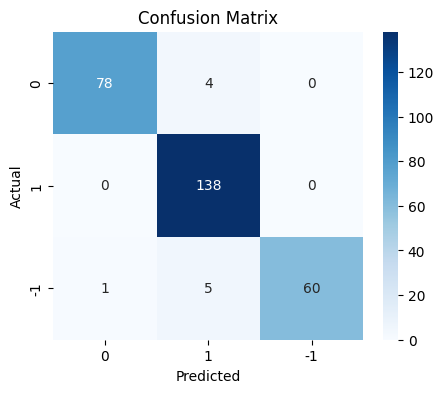

In [ ]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

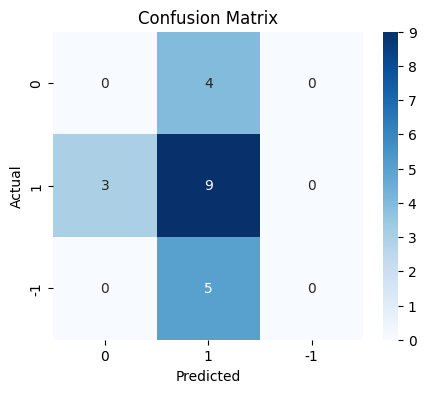

In [ ]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

**Let's print Training performance:**

In [ ]:
# Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.965035  0.965035   0.966829  0.964869


**Let's print Validation performance:**

In [ ]:
# Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.285714  0.342857


- Train F1 score of 0.96 and validation F1 score of ~0.34 indicate poor performance of the model between training and validation datasets while calculating using weighted average.

**Classification Report**

In [ ]:
# Print classification report on training data
print(classification_report(y_train, tuned_wv.predict(X_train_wv)))

              precision    recall  f1-score   support

          -1       0.99      0.95      0.97        82
           0       0.94      1.00      0.97       138
           1       1.00      0.91      0.95        66

    accuracy                           0.97       286
   macro avg       0.98      0.95      0.96       286
weighted avg       0.97      0.97      0.96       286



In [ ]:
# Print classification report on validation data
print(classification_report(y_val, tuned_wv.predict(X_val_wv)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.50      0.75      0.60        12
           1       0.00      0.00      0.00         5

    accuracy                           0.43        21
   macro avg       0.17      0.25      0.20        21
weighted avg       0.29      0.43      0.34        21



**Observations**
  - For class -1, Train and validaiton F1 Score is 0.97 and 0 respectively and shows overfitting.
  - For class 0, Train and validaiton F1 Score is 0.97 and 0.60 respectively and shows overfitting.
  - For class 1, Train and validaiton F1 Score is 0.95 and 0 respectively and shows overfitting.
  - Model seems much Bias towards class 0 while predecting if we compare from any other class
  - Model failed for predecting classes -1 and 1 entirely.

### **Tuned Model - GloVe**

In [ ]:
models_train_glove_f1_score = []  # Empty list to store all the training score
models_validation_glove_f1_score = []  # Empty list to store all the validation score
models_glove_est = [] # Empty list to store all the best estimator

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

for name, model in models:
    # Run the grid search
    grid_obj = RandomizedSearchCV(model, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
    grid_obj = grid_obj.fit(X_train_gl, y_train)
    # Set the clf to the best combination of parameters
    tuned_gl = grid_obj.best_estimator_
    # Fit the best algorithm to the data.
    tuned_gl.fit(X_train_gl, y_train)
    models_glove_est.append((name,tuned_gl))
    # Calculate f1 scores
    scores_f1 = f1_score(y_train, tuned_gl.predict(X_train_gl), average='weighted')
    models_train_glove_f1_score.append((name,scores_f1))
    scores_val_f1 = f1_score(y_val, tuned_gl.predict(X_val_gl), average='weighted')
    models_validation_glove_f1_score.append((name,scores_val_f1))


# Convert models list into 2 columns data frame
models_train_glove_f1_score_df = pd.DataFrame(models_train_glove_f1_score, columns=['Model Name', 'F1 Score'])
models_validation_glove_f1_score_df = pd.DataFrame(models_validation_glove_f1_score, columns=['Model Name', 'F1 Score'])

# Merge models_train_glove_f1_score_df and models_validation_glove_f1_score_df into one data frame
models_score_glove_df = pd.merge(models_train_glove_f1_score_df, models_validation_glove_f1_score_df, on='Model Name', suffixes=('_train_W2V', '_val_W2V'))

In [ ]:
# Print the weighted F1 Score for each model
models_score_glove_df

,Model Name,F1 Score_train_W2V,F1 Score_val_W2V
0,Random forest,0.982463,0.530612
1,GBM,1.000000,0.567284
2,dtree,0.680121,0.392857


- **Observations**
  - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set.
  - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set.
  - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set but shows slghtly better performance than other models.
    
**Next Steps**
 - Let’s proceed to use GBM model to determine detailed performs on both training and validation sets, aiming to check the highest F1 score.

In [ ]:
models_glove_est

[('Random forest',
  RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=5,
                         random_state=42)),
 ('GBM',
  GradientBoostingClassifier(max_depth=6, max_features='log2',
                             min_samples_split=7, random_state=42)),
 ('dtree',
  DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_split=11,
                         random_state=42))]

In [ ]:
# Assigning an instance of best performing Model
tuned_gl = models_glove_est[1][1]

In [ ]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train)

GradientBoostingClassifier(max_depth=6, max_features='log2',
                           min_samples_split=7, random_state=42)

**Let's print the Confusion matrix**

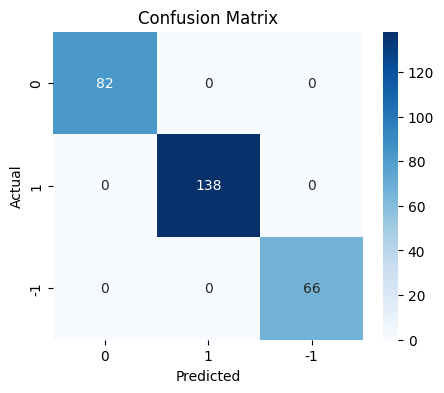

In [ ]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

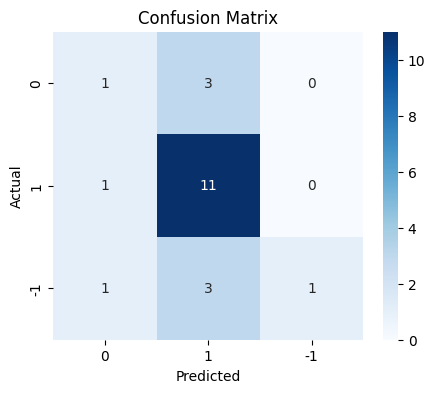

In [ ]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

**Let's print Training performance:**

In [ ]:
# Calculating different metrics on training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


**Let's print Validation performance:**

In [ ]:
# Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.619048  0.619048   0.671335  0.567284


- Train F1 score of 1 and validation F1 score of ~0.56 indicate poor performance of the model between training and validation datasets while calculating using weighted average but better than other models.

**Classification Report**

In [ ]:
#Print classification report on training data
print(classification_report(y_train, tuned_gl.predict(X_train_gl)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        82
           0       1.00      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286



In [ ]:
#Print classification report on validation data
print(classification_report(y_val, tuned_gl.predict(X_val_gl)))

              precision    recall  f1-score   support

          -1       0.33      0.25      0.29         4
           0       0.65      0.92      0.76        12
           1       1.00      0.20      0.33         5

    accuracy                           0.62        21
   macro avg       0.66      0.46      0.46        21
weighted avg       0.67      0.62      0.57        21



**Observations**
  - For class -1, Train and validaiton F1 Score is 1 and 0.29 respectively and shows overfitting.
  - For class 0, Train and validaiton F1 Score is 1 and 0.76 respectively and shows overfitting.
  - For class 1, Train and validaiton F1 Score is 1 and 0.33 respectively and shows overfitting.
  - Model seems much Bias towards class 0 while predecting if we compare from any other class
  - Model failed for predecting classes.

### **Tuned Model - Sentence Transformer**

In [ ]:
models_train_st_f1_score = []  # Empty list to store all the training score
models_validation_st_f1_score = []  # Empty list to store all the validation score
models_st_est = [] # Empty list to store all the best estimator

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

for name, model in models:
    # Run the grid search
    grid_obj = RandomizedSearchCV(model, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
    grid_obj = grid_obj.fit(X_train_st, y_train)
    # Set the clf to the best combination of parameters
    tuned_st = grid_obj.best_estimator_
    # Fit the best algorithm to the data.
    tuned_st.fit(X_train_st, y_train)
    models_st_est.append((name,tuned_st))
    # Calculate f1 scores
    scores_f1 = f1_score(y_train, tuned_st.predict(X_train_st), average='weighted')
    models_train_st_f1_score.append((name,scores_f1))
    scores_val_f1 = f1_score(y_val, tuned_st.predict(X_val_st), average='weighted')
    models_validation_st_f1_score.append((name,scores_val_f1))


# Convert models list into 2 columns data frame
models_train_st_f1_score_df = pd.DataFrame(models_train_st_f1_score, columns=['Model Name', 'F1 Score'])
models_validation_st_f1_score_df = pd.DataFrame(models_validation_st_f1_score, columns=['Model Name', 'F1 Score'])

# Merge models_train_st_f1_score_df and models_validation_st_f1_score_df into one data frame
models_score_st_df = pd.merge(models_train_st_f1_score_df, models_validation_st_f1_score_df, on='Model Name', suffixes=('_train_ST', '_val_ST'))


In [ ]:
# Print the weighted F1 Score for each model
models_score_st_df

,Model Name,F1 Score_train_ST,F1 Score_val_ST
0,Random forest,0.996499,0.415584
1,GBM,1.000000,0.392857
2,dtree,0.703814,0.272727


- **Observations**
  - **Decision Tree** Appears to be overfitting training sets, and performs poorly on the validation set.
  - **Random forest** Also shows overfitting on training sets, resulting in poor performance on the validation set but shows slghtly better performance than other models.
  - **GBM** Also shows overfitting on training sets, resulting in poor performance on the validation set.
    
**Next Steps**
 - Let’s proceed to use Random Forest model to determine detailed performs on both training and validation sets, aiming to check the highest F1 score.

In [ ]:
models_st_est

[('Random forest',
  RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=11,
                         random_state=42)),
 ('GBM',
  GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                             min_samples_split=5, random_state=42)),
 ('dtree',
  DecisionTreeClassifier(max_depth=6, max_features='log2', min_samples_split=7,
                         random_state=42))]

In [ ]:
# Assigning an instance of best performing Model
tuned_st = models_st_est[0][1]

In [ ]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train)

RandomForestClassifier(max_depth=6, max_features=0.2, min_samples_split=11,
                       random_state=42)

**Let's print the Confusion matrix**

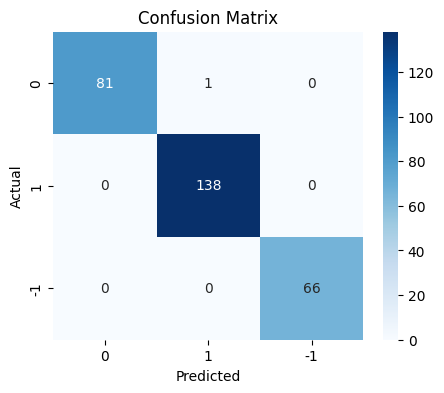

In [ ]:
# Plot the confusion matrix for the train data
plot_confusion_matrix(tuned_st,X_train_st,y_train)

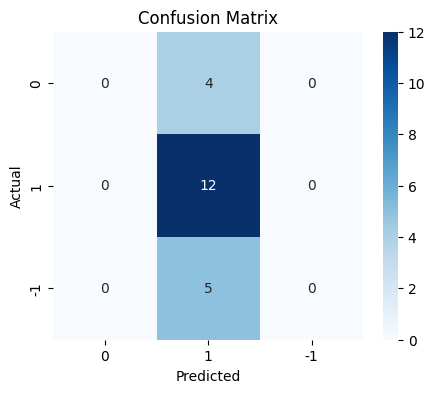

In [ ]:
# Plot the confusion matrix for the validation data
plot_confusion_matrix(tuned_st,X_val_st,y_val)

**Let's print Training performance:**

In [ ]:
# Calculating different metrics on training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.996503  0.996503   0.996529  0.996499


**Let's print Validation performance:**

In [ ]:
# Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.571429  0.571429   0.326531  0.415584


- Train F1 score of .99 and validation F1 score of ~0.41 indicate poor performance of the model between training and validation datasets while calculating using weighted average.

**Classification Report**

In [ ]:
# Print classification report on training data
print(classification_report(y_train, tuned_st.predict(X_train_st)))

              precision    recall  f1-score   support

          -1       1.00      0.99      0.99        82
           0       0.99      1.00      1.00       138
           1       1.00      1.00      1.00        66

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286



In [ ]:
# Print classification report on validation data
print(classification_report(y_val, tuned_st.predict(X_val_st)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.57      1.00      0.73        12
           1       0.00      0.00      0.00         5

    accuracy                           0.57        21
   macro avg       0.19      0.33      0.24        21
weighted avg       0.33      0.57      0.42        21



**Observations**
  - For class -1, Train and validaiton F1 Score is 0.99 and 0 respectively and shows overfitting.
  - For class 0, Train and validaiton F1 Score is 1 and 0.73 respectively and shows overfitting.
  - For class 1, Train and validaiton F1 Score is 1 and 0 respectively and shows overfitting.
  - Model seems much Bias towards class 0 while predecting if we compare from any other class
  - Model failed for predecting class -1 and 1 entirely.

### **Model Performance Summary and Final Model Selection**

In [ ]:
# Training performance comparison
models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,0.965035,1.0,0.996503
Recall,1.0,1.0,1.0,0.965035,1.0,0.996503
Precision,1.0,1.0,1.0,0.966829,1.0,0.996529
F1,1.0,1.0,1.0,0.964869,1.0,0.996499


In [ ]:
# Validation performance comparison
models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.333333,0.428571,0.619048,0.428571,0.619048,0.571429
Recall,0.333333,0.428571,0.619048,0.428571,0.619048,0.571429
Precision,0.375000,0.458503,0.533333,0.285714,0.671335,0.326531
F1,0.338462,0.438672,0.504762,0.342857,0.567284,0.415584


* **Observations**
 - After comparing the performance of the **F1 score** among all tuned models for training and on the validation dataset, **Tuned GBM with Glove** emerged as the clear winner.

  - Among the different Tuned models **Tuned GBM with Glove** model shows comparatively better performance, However all Models either base OR tuned shows Overfitting due to lack of data specifically for Class 1. This model not only has the highest F1 score but also comparable higher Recall and Precision scores.

  - Due to the nature of the requirement, we mainly focused on the **F1 score** while choosing the model, with Recall and Precision scores being secondary priorities.

**Conclusion for Final Model Selection while using recall mertic OR weighted average**

* **Tuned Model with Glove** model shows better performace when compare all  metrices like Recall, Accuracy, precision and F1 while calculating for weighted average.

### **Model Performance Check on Test Data**

**Let's print the Confusion matrix**

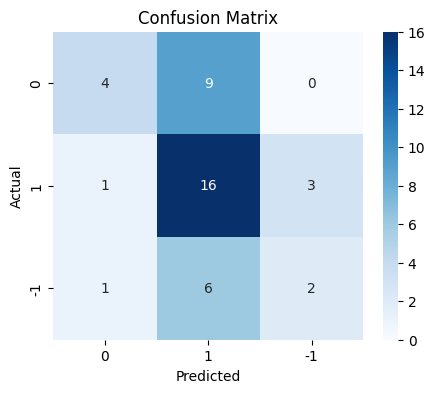

In [ ]:
# Plot the confusion matrix for the final model and test data
plot_confusion_matrix(tuned_gl,X_test_gl,y_test)

**Let's print Test performance:**

In [ ]:
# Calculating different metrics on test data
test_wv=model_performance_classification_sklearn(tuned_gl,X_test_gl,y_test)
print("Test performance:\n",test_wv)

Test performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.537839  0.490336


* **Tuned Model with Glove** is giving .49 F1 score on the test data set while calculating for weighted average.

**Let's print Classification Report:**

In [ ]:
# Print classification report on test data
print(classification_report(y_test, tuned_gl.predict(X_test_gl)))

              precision    recall  f1-score   support

          -1       0.67      0.31      0.42        13
           0       0.52      0.80      0.63        20
           1       0.40      0.22      0.29         9

    accuracy                           0.52        42
   macro avg       0.53      0.44      0.44        42
weighted avg       0.54      0.52      0.49        42



**Final Conclusion**

**Tuned Model with Glove** on Test data..
  - For class -1, Test F1 is .42
  - For class 0, Test F1 is .63
  - For class 1, Test F1 is .29

**Tuned Model with Glove** is giving the highest F1 i.e ~.63 on the test set for class 0.

## **Weekly News Summarization**

#### Installing and Importing the necessary libraries

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 270.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 286.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.2.1 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.1 which is incompatible.
langchain 0.3.12 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.2.1 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.2.1

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

# For progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

#### Loading the data

In [ ]:
# Read .cvs file in dataframe
stock_news_summ = pd.read_csv('/content/drive/MyDrive/python/NLP/Project/stock_news.csv')

In [ ]:
# Creating a copy of the data
stock_news_summ_df = stock_news_summ.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"


model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
llm = Llama(
    model_path=model_path,
    n_gpu_layers=100,
    n_ctx=4500,
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


#### Aggregating the data weekly

In [ ]:
# Convert the 'Date' column to datetime format.
stock_news_summ_df["Date"] = pd.to_datetime(stock_news_summ_df['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = stock_news_summ_df.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
# Group the New data by week.
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
# Creating a copy of the data
weekly_data_df = weekly_grouped.copy()

#### Summarization

##### Utility Functions

In [ ]:
# Defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
# Defining the response function
def get_mistral_response(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=400,
      temperature=0.05,
      top_p=0.9,
      top_k=40,
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

In [ ]:
# Get one sample from News Column
sample_news = weekly_data_df.loc[0, 'News']

In [ ]:
# Print sample from news dataset
print(len(sample_news.split(' ')))
sample_news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
# Define the prompt for this task
prompt = """
    You're an expert in stock market new summarization.
    You will be provided with multiple articles, each sepearated by ' || '.
    Read through each of the news articles and extract the top three postitve and negative aspects that could potentially impact the price of stocks.
    Consider factors such as market trends, company announcements, economic indicators, and any other relevant informtaion
    Return in a JSON format as follows:
    {"Positive Aspects": [pint_1, point_2, point_3], "Negative Aspects":[point_1,point_2,point_3]}
    Return only the JSON  object, nothing else.
"""

In [ ]:
# Print Summary as per provided prompt for sample News article
%%time
news_summary = get_mistral_response(prompt, sample_news)
print(news_summary)

{"Positive Aspects": [
          "Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.",
          "Gold prices reached over six-month highs due to investor concerns over a global economic slowdown and stock market volatility.",
          "The Chinese central bank announced a fifth reduction in the required reserve ratio (RRR) for banks, freeing up approximately 116.5 billion yuan for new lending."
        ],
        "Negative Aspects": [
          "Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales.",
          "Yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown.",
          "Apple's revenue warning led to significant declines

##### Checking the model output on the weekly data

In [ ]:
# Create a new column storing Summary for each News article weekly using Mistral model
%%time
weekly_data_df['Key Events'] = weekly_data_df['News'].progress_apply(lambda x: get_mistral_response(prompt,x))

100%|██████████| 18/18 [04:03<00:00, 13.53s/it]

CPU times: user 3min 33s, sys: 28.9 s, total: 4min 2s
Wall time: 4min 3s


In [ ]:
# Print the first 5 rows of the 'Key_Events' column
weekly_data_df['Key Events'].head()

,Key Events
0,"{""Positive Aspects"": [\n ""Roku Inc announced plans to off..."
1,"{""Positive Aspects"": [\n ""Sprint and Samsung planning to re..."
2,"{""Positive Aspects"": [\n ""Apple's partnership with TD Ameri..."
3,"{""Positive Aspects"": [\n ""IBM reported better-than-expected..."
4,"{""Positive Aspects"": [\n ""Apple reported stronger-than-expe..."


##### Formatting the model output

In [ ]:
# Parsed and extract the Summarize data from New column
weekly_data_df['model_response_parsed'] = weekly_data_df['Key Events'].apply(extract_json_data)
weekly_data_df.head()

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant decline in the aftermar...,"{""Positive Aspects"": [\n ""Roku Inc announced plans to off...",{'Positive Aspects': ['Roku Inc announced plans to offer premium v...
1,2019-01-13,Sprint and Samsung plan to release 5G smartphones in nine U.S. ci...,"{""Positive Aspects"": [\n ""Sprint and Samsung planning to re...",{'Positive Aspects': ['Sprint and Samsung planning to release 5G s...
2,2019-01-20,The U.S. stock market declined on Monday as concerns over a globa...,"{""Positive Aspects"": [\n ""Apple's partnership with TD Ameri...",{'Positive Aspects': ['Apple's partnership with TD Ameritrade enab...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andrea Maechler, stated t...","{""Positive Aspects"": [\n ""IBM reported better-than-expected...",{'Positive Aspects': ['IBM reported better-than-expected earnings ...
4,2019-02-03,Caterpillar Inc reported lower-than-expected fourth quarter earni...,"{""Positive Aspects"": [\n ""Apple reported stronger-than-expe...",{'Positive Aspects': ['Apple reported stronger-than-expected earni...


In [ ]:
# Normalize the Summary
model_response_parsed = pd.json_normalize(weekly_data_df['model_response_parsed'])
model_response_parsed.head()

,Positive Aspects,Negative Aspects
0,[Roku Inc announced plans to offer premium video channels on a sub...,[Apple lowered its fiscal Q1 revenue guidance to $84 billion from ...
1,[Sprint and Samsung planning to release 5G smartphones in nine U.S...,[Geely forecasting flat sales for 2019 due to economic slowdown an...
2,[Apple's partnership with TD Ameritrade enabling instant account f...,"[Unexpected drops in China's exports and imports, leading to globa..."
3,"[IBM reported better-than-expected earnings and revenue, with its ...",[Swiss National Bank governor emphasized the need for negative int...
4,"[Apple reported stronger-than-expected earnings for Q1 2023, Gold ...",[Caterpillar Inc reported lower-than-expected fourth quarter earni...


In [ ]:
# Prepare dataset with Date, News and corresponding Positive and Negative events from News artcile
final_output = pd.concat([weekly_data_df.reset_index(drop=True),model_response_parsed],axis=1)

final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant decline in the aftermar...,[Roku Inc announced plans to offer premium video channels on a sub...,[Apple lowered its fiscal Q1 revenue guidance to $84 billion from ...
1,2019-01-13,Sprint and Samsung plan to release 5G smartphones in nine U.S. ci...,[Sprint and Samsung planning to release 5G smartphones in nine U.S...,[Geely forecasting flat sales for 2019 due to economic slowdown an...
2,2019-01-20,The U.S. stock market declined on Monday as concerns over a globa...,[Apple's partnership with TD Ameritrade enabling instant account f...,"[Unexpected drops in China's exports and imports, leading to globa..."
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andrea Maechler, stated t...","[IBM reported better-than-expected earnings and revenue, with its ...",[Swiss National Bank governor emphasized the need for negative int...
4,2019-02-03,Caterpillar Inc reported lower-than-expected fourth quarter earni...,"[Apple reported stronger-than-expected earnings for Q1 2023, Gold ...",[Caterpillar Inc reported lower-than-expected fourth quarter earni...


## **Conclusions and Recommendations**

### **Conclusions**




- **Sentiment Analysis of News Articles**:  
  - Conducted an in-depth analysis of the sentiment distribution across historical news articles related to the company's stock performance.  

- **Word Embedding Creation**:  
  - Leveraged advanced embedding techniques to represent the text data:  
    - **Word2Vec**: Generated embeddings with 300 dimensions.  
    - **GloVe**: Created embeddings with 100 dimensions.  
    - **all-MiniLM-L6-v2 Transformer Model**: Produced embeddings with 384 dimensions.  

- **Machine Learning Model Development**:  
  - Implemented the following machine learning models to predict sentiment based on the embeddings:  
    - Decision Tree  
    - Random Forest  
    - Gradient Boosting  
  - Initial results indicated that the **Random Forest model** using **all-MiniLM-L6-v2 embeddings** achieved an F1 score of 50% on the validation dataset. However, all models exhibited significant overfitting.  

- **Hyperparameter Tuning**:  
  - Conducted extensive hyperparameter optimization using Random Search to improve performance.  
  - Post-tuning, the **Gradient Boosting model with GloVe embeddings** achieved an F1 score of 56% on the validation dataset. Despite improvements, overfitting persisted.  
  - On the test dataset, the tuned Random Forest model with GloVe achieved an F1 score of 49%, indicating further tuning or alternative modeling approaches may be required.  

- **Utilization of Large Language Models (LLMs)**:  
  - Implemented an LLM-based workflow for enhanced sentiment analysis and news summarization:  
    1. Grouped news articles by week to enable time-based aggregation.  
    2. Designed a custom prompt to generate JSON-formatted summaries highlighting both positive and negative aspects of the news.  
    3. Summarized individual articles while normalizing sentiment into clear positive and negative categories.  

- **Actionable Insights for Investment Strategies**:  
  - The sentiment categorizations provide actionable insights, helping the organization interpret stock-related news and its influence on daily stock prices and trade volumes.  
  - Weekly summarizations enhance the accuracy of stock price predictions, enabling optimization of investment strategies.  

- **Business Value and Strategic Impact**:  
  - The developed AI system empowers financial analysts with tools to process and analyze high volumes of news articles automatically.  
  - The integration of sentiment insights into investment decisions facilitates improved accuracy in predictions, leading to more informed and strategic decision-making.  
  - These advancements strengthen the organization's ability to deliver superior client outcomes in a competitive financial landscape.  

### **Recommendations**

- **Current Model Performance**:  
  - The sentiment analysis model currently achieves an F1 score of 49% on the test dataset, indicating limitations in its ability to accurately categorize news articles.  

- **Data Augmentation Recommendation**:  
  - To enhance model performance, it is recommended to expand the training dataset by collecting additional news articles, particularly those explicitly labeled with **Positive** and **Negative** sentiments. A more diverse and balanced dataset will improve the model's ability to generalize and predict sentiments in unseen news.  

- **Model Fine-Tuning**:  
  - Fine-tuning the model on this specific dataset with clearly defined sentiment labels (e.g., -1 for Negative and 1 for Positive) could significantly enhance predictive accuracy.  

- **Exploration of Advanced Transformer Models**:  
  - The startup can explore alternative transformer-based models to generate more comprehensive and contextually accurate summaries of news articles. This approach can provide a clearer and more concise overview of the content.  

- **Enhancing Weekly Summaries**:  
  - To improve the quality and relevance of weekly news summaries, the following strategies can be adopted:  
    1. **Prompt Refinement**: Update the LLM prompt with more specific details, structured formatting, and clear instructions to produce higher-quality outputs.  
    2. **Parameter Optimization**: Experiment with model parameters such as `temperature`, `top_p`, and others to better control the output's coherence and diversity.  

- **Strategic Benefits**:  
  - By addressing these recommendations, the startup can significantly improve the sentiment analysis system's accuracy, provide richer and actionable insights, and enhance the quality of weekly summaries to better support data-driven investment strategies.  

<font size=6 color='blue'>Power Ahead</font>
___